# Prediccíon de "churn"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data_science_exercise_dataset.csv")

## Preprocesamiento de valores nulos

In [ ]:
na_per = 100*((df.shape[0] - df.dropna().shape[0])/df.shape[0])

In [ ]:
print("Porcentaje de observaciones con valores nulos: {}%".format(na_per))

Porcentaje de observaciones con valores nulos: 4.675%


Las variables con valores nulos son <code>country_region</code> y <code>city</code>

In [ ]:
df.isna().mean()

user_id                   0.00000
install_time              0.00000
platform                  0.00000
country_region            0.02395
city                      0.04675
gender                    0.00000
min_age_range             0.00000
max_age_range             0.00000
event_1                   0.00000
event_2                   0.00000
event_3                   0.00000
event_4                   0.00000
event_5                   0.00000
target_churn_indicator    0.00000
dtype: float64

Voy a dropear los valornes nulos ya que solo representan el 5% de los datos, pero antes necesito entender:

1. Si los valores nulos en <code>country_region</code> ser corresponden con los de <code>city</code> 
2. El impacto en la distribución de la variable de respuesta, al remover estas observaciones.

### Punto 1: Valores nulos "country_region" vs "city"

El punto 1 queda confirmado, ya que el total de obvervaciones con al menos una variable nula, es igual a la cantidad de observaciones nulas en la variable <code> city </code>

In [ ]:
df[["country_region","city"]].isna().sum()

country_region    479
city              935
dtype: int64

In [ ]:
df.isna().any(axis=1).sum()

935

### Punto 2: Distribución "target_churn_indicator" pre/post procesamiento de valores nulos

In [ ]:
na_removed = df.dropna()

In [ ]:
print("Churn rate a priori, con valores nulos:  {:.2f}%".format(df["target_churn_indicator"].mean()*100))
print("Churn rate a priori, sin valores nulos:  {:.2f}%".format(na_removed["target_churn_indicator"].mean()*100))

Churn rate a priori, con valores nulos:  54.07%
Churn rate a priori, sin valores nulos:  53.62%


La tasa de "churn" baja un poco al eliminar los valores nulos.
Voy a elimnar los valores nulos aceptando que el modelo que que construya corra riesgo de ser "optimista".

In [ ]:
df = na_removed
df.shape[0]

19065

## EDA

Voy a comenzar realizando un análysis exploratorio de las variables

In [ ]:
df.head(2)

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator
0,2ba6f357,2018-07-04 19:24:24,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,0,1,1,0
1,3cb936c1,2018-06-30 13:41:29,Android,Corrientes,Corrientes,male,13,17,0,7,0,3,0,1


### Análisis de correlación

In [ ]:
import seaborn as sns

#### Exploramos la variables de "edad"

Vemos que ambas variables de edad, parecen tener un fuerte correlación.

In [ ]:
df[["target_churn_indicator","min_age_range", "max_age_range"]].corr()

,target_churn_indicator,min_age_range,max_age_range
target_churn_indicator,1.000000,-0.038340,-0.038819
min_age_range,-0.038340,1.000000,0.997931
max_age_range,-0.038819,0.997931,1.000000


De las dos tablas de abajo, también podemos observar que podríamos modelar la edad como una variable discreta, ya que la mayoría de los valores están concentrados en 13, 18 (para la variable "min_age_range"), 17 y 20 (para la variable "max_age_range").

También notamos como <code>min_age_range</code> llega hasta el valor 21, cuando <code>max_age_range</code> solo llega hasta 20.

Asumo que esto es un error de carga, por lo que corregiré estos potenciales errores en la sección dedicada a "Preprocesamiento e Ingeniería de atributos".

In [ ]:
df[["target_churn_indicator","min_age_range"]].groupby("min_age_range").count()

,target_churn_indicator
min_age_range,
13,7073
17,2
18,11973
20,2
21,15


In [ ]:
df[["target_churn_indicator","max_age_range"]].groupby("max_age_range").count()

,target_churn_indicator
max_age_range,
13,1
17,7078
18,2
20,11984


#### Exploramos las variables de "eventos"

Me interesa analizar la correlación de las variables de tipo "evento" para entender si hay colinearidad entre ellas.

In [ ]:
corr_df_events = df[["target_churn_indicator","event_1","event_2","event_3","event_4","event_5"]]

In [ ]:
from sklearn.preprocessing import StandardScaler

Si bien la diferencia de órdenes de magnitud entre las variables de tipo "evento" no es amplia, voy a estandarizar sus escalas, ya que quiero entender:

1. Si hay una relación lineal entre estas variables (para esto estandarizo), y
2. Como se relacionan con la variable de respuesta

In [ ]:
se = StandardScaler()

In [ ]:
scaled_df = se.fit_transform(corr_df_events)

C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
scaled_df = pd.DataFrame(scaled_df, columns = corr_df_events.columns)

En el siguiente pairplot observamos que:

1. No hay una relación lineal entre las variables de tipo "evento", por lo que NO tiene sentido calcular la correlación entre las mismas.
2. Valores altos de los eventos 2,3 y 4, parecen estar asociades con una baja tasa de churn.

C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


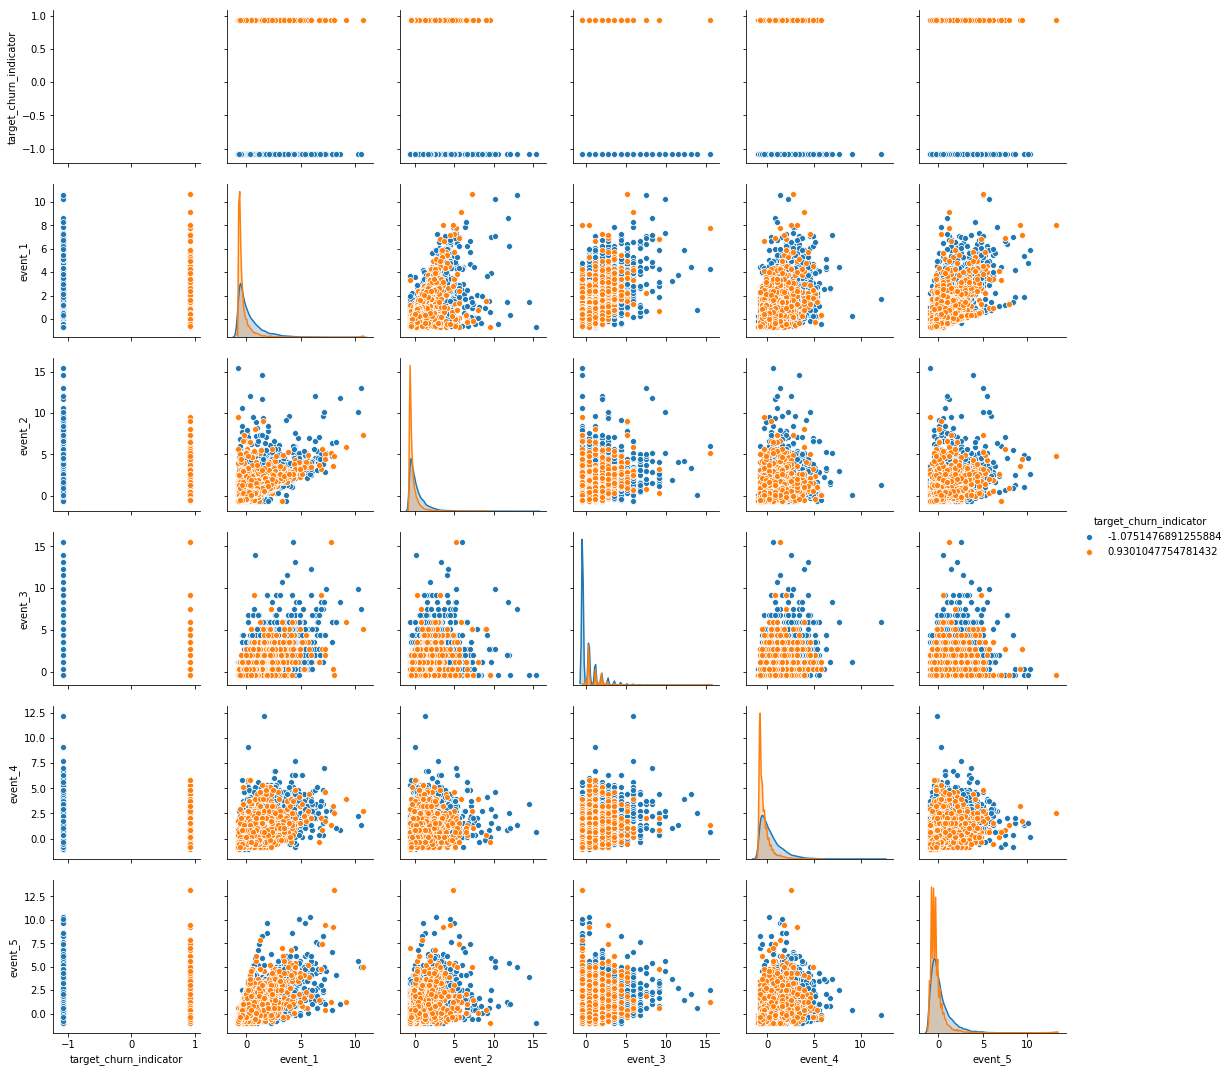

In [ ]:
sns.pairplot(scaled_df, hue = "target_churn_indicator")

## Preprocesamiento e Ingeniería de Atributos

### Día de descarga vs Churn

Hay alguna relación entre la hora de instalación y el "churn rate"?

Una simple hipótesis, es que el "churn rate" está asociado a la hora y el día en que una persona instala la app (i.e mientras viaja al trabajo, un Domingo a la mañana, una madrugada de insomnio, etc.) 

**Nota**: Estas son meras hipótesis, y la intención de este analysis no es "probarlas", sino que sirvan de generación de ideas para crear nuevos atributos que mejoren la performance de los modelos de clasificación.

In [ ]:
df["install_time"] = pd.to_datetime(df["install_time"],format='%Y%m%d %H:%M:%S')

In [ ]:
df["date"] = df["install_time"].dt.date

In [ ]:
df[["date","target_churn_indicator"]].groupby("date").count()

,target_churn_indicator
date,
2018-06-30,2196
2018-07-01,2704
2018-07-02,2354
2018-07-03,2486
2018-07-04,2247
2018-07-05,2199
2018-07-06,2289
2018-07-07,2590


In [ ]:
df[["date","target_churn_indicator"]].groupby("date").mean()

,target_churn_indicator
date,
2018-06-30,1.000000
2018-07-01,0.479290
2018-07-02,0.462192
2018-07-03,0.471842
2018-07-04,0.457944
2018-07-05,0.472033
2018-07-06,0.473569
2018-07-07,0.508880


Viendo las tablas de arriba y el siguiente gráfico, veo una tasa de churn de 100% durante el mes de Junio del 2018.

El día "2018-06-30" fue Sábado. Interpreto que la intención fue agregar más observaciones con "churn" al día Sábado para forzar un patrón.

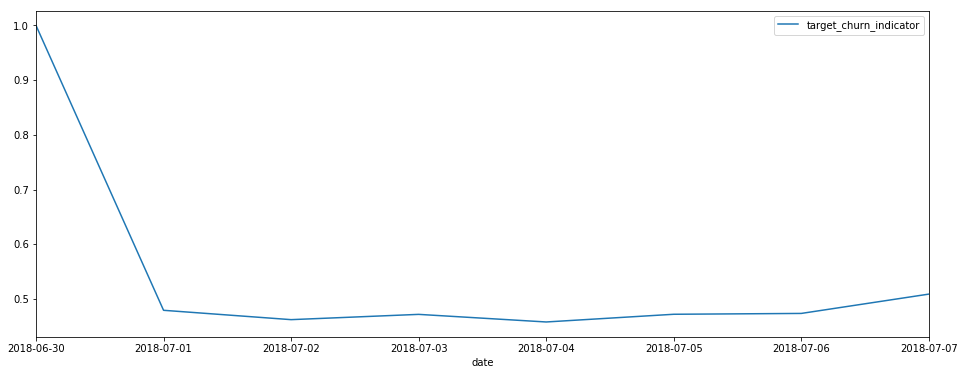

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
_=df[["date","target_churn_indicator"]].groupby("date").mean().plot(ax =ax)

In [ ]:
df = df.drop(columns=["date"])

In [ ]:
#creo un diccionario para mapear los días de la semana
dayDict = {
    0:"mon",
    1:"tue",
    2:"wed",
    3:"thu",
    4:"fri",
    5:"sat",
    6:"sun"
}

In [ ]:
#creo la variable "day" que contiene el día de la semana
df["day"] = df["install_time"].dt.dayofweek.apply(lambda x: dayDict[x])
#cuento las observaciones por día
installs_by_day  = pd.DataFrame(df["day"].value_counts())
installs_by_day.columns = ["number_of_installs"]
installs_by_day

,number_of_installs
sat,4786
sun,2704
tue,2486
mon,2354
fri,2289
wed,2247
thu,2199


In [ ]:
#calculo el churn rate por día
churn_rate_by_day = df[["day","target_churn_indicator"]].groupby("day").mean().sort_values("target_churn_indicator", ascending=False)

In [ ]:
#junto los dataframes
installs = installs_by_day.join(churn_rate_by_day, how ="inner")
installs.reset_index(inplace=True)

In [ ]:
# este bloque de código es para ordenar el dataframe en base a los días, empezando desde el Lunes
weekdays = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
mapping = {day: i for i, day in enumerate(weekdays)}
key = installs['index'].map(mapping)

In [ ]:
installs = installs.iloc[key.argsort()]
installs=installs.reset_index(drop=True)
installs = installs.rename(columns={"index":"day", "target_churn_indicator":"churn_rate"})

In [ ]:
installs

,day,number_of_installs,churn_rate
0,mon,2354,0.462192
1,tue,2486,0.471842
2,wed,2247,0.457944
3,thu,2199,0.472033
4,fri,2289,0.473569
5,sat,4786,0.734225
6,sun,2704,0.479290


En el siguiente gráfico, observamos como el día "Sábado", es el día con mayor número de instalaciones, pero también con una alta tasa de "bajas" (los usuarios no jugaron al día siguiente).

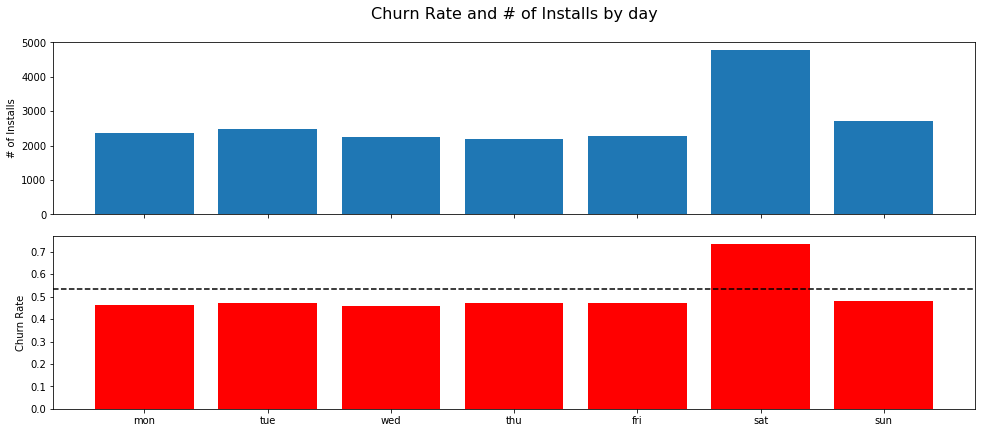

In [ ]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 0.05, 0.8, 0.4],
                  xticklabels=["blank"]+installs["day"].tolist())

_=ax2.bar(range(installs.shape[0]),installs["churn_rate"], color="red")
_= ax2.set_ylabel("Churn Rate")

_=ax2.axhline(df["target_churn_indicator"].mean(), color="black", linestyle="--")
                 
_=ax1.bar(range(installs.shape[0]),installs["number_of_installs"])
_= ax1.set_ylabel("# of Installs")


_= fig.suptitle('Churn Rate and # of Installs by day', fontsize=16)
plt.savefig('churn_rate_day.png')

El Sábado parece ser el único día con una proporcion marginal de bajas, significativamente distinta a los demás días.

### Hora de descarga vs Churn

Simlar al día, hay relación entre la hora de descarga y la tasa de "bajas"?

In [ ]:
#creamos una variable que capture la hora de instalación
df["install_hour"] = df["install_time"].dt.hour

In [ ]:
#graficamos
installs_by_hour  = pd.DataFrame(df["install_hour"].value_counts())
installs_by_hour.columns = ["number_of_installs"]
installs_by_hour = installs_by_hour.reset_index()
installs_by_hour = installs_by_hour.sort_values(by=['index'])
installs_by_hour = installs_by_hour.set_index("index")

Vemos que los picos de instalación,se dan de las 23hs a las 2AM.
También podemos observar un disminución en la cantidad de descargas a altas ahoras de la madrugada (horario en que la mayoría de la gente duerme), llegando a mínimos diarios por las 9AM, punto en el cual el número de instalaciones, comienza a crecer nuevamente.

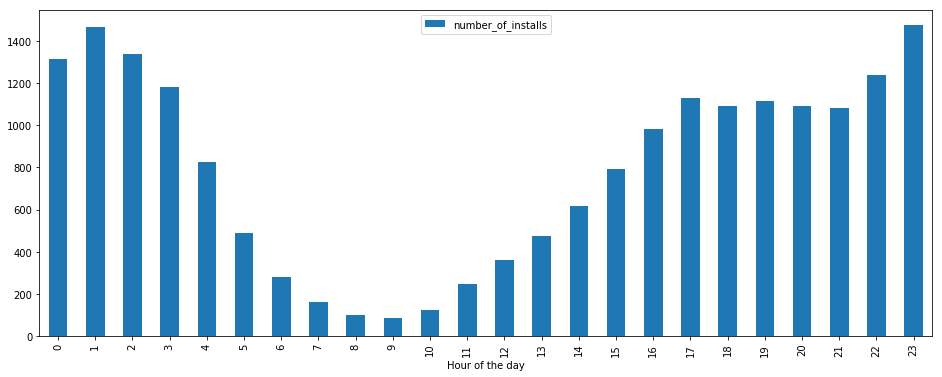

In [ ]:
_=installs_by_hour.plot(kind="bar", figsize = (16,6))
_=plt.xlabel("Hour of the day")
plt.savefig('installs_por_hora.png')

In [ ]:
pd.crosstab(df["install_hour"], df["target_churn_indicator"]).head(4)

target_churn_indicator,0,1
install_hour,,
0,600,715
1,722,743
2,659,680
3,561,622


In [ ]:
#crea el dataframe con las horas y el "count" de la variable de respuesta
churn_by_hour = pd.crosstab(df["install_hour"], df["target_churn_indicator"])
churn_by_hour.columns = ["no", "yes"]
#creo una variable para capturar el "churn rate" por hora
churn_by_hour["churn_rate"] = churn_by_hour["yes"]/churn_by_hour.sum(axis=1)

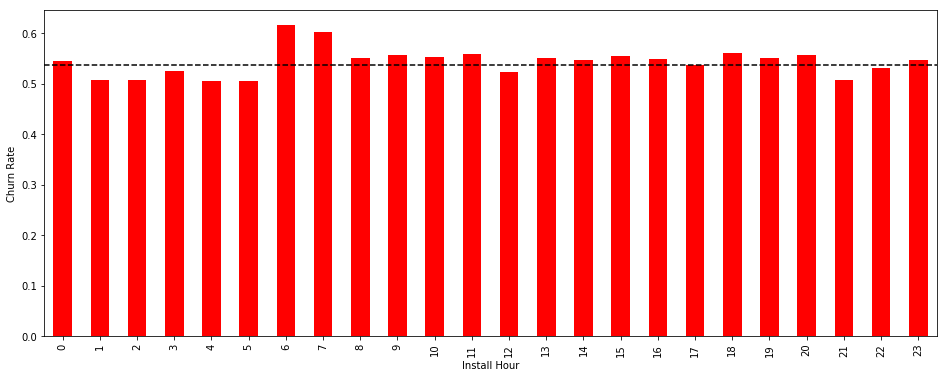

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
_=churn_by_hour["churn_rate"].plot(kind="bar", figsize = (16,6), color="red")
_=ax.axhline(df["target_churn_indicator"].mean(), color="black", linestyle="--")
plt.xlabel("Install Hour")
plt.ylabel("Churn Rate")
plt.savefig('churnrate_por_hora.png')

El "churn rate" pasa a ser ligeramente más bajo en horas de la madrugada (en algunos casos coincide con los picos de descarga/instalación de la app i.e 1-2am).

El "churn rate" mas alto, se observa por las 6 y 7 de la mañana. También sabemos que durante estas horas, hay una caida en la cantidad de descargas de la app (el número de descargas es mucho menor al del resto de las horas del día), por lo que podría tratarse de pesonas que instalan la app, mientras van a su trabajo/escuela para pasar el rato, pero no vuelven a usarla al día siguiente.

In [ ]:
#De todas formas crearemos una variable para capturar este patrón de alto "churn rate".
df["am_7_8"]=df["install_hour"].apply(lambda x: 1 if (x == 6 or x==7) else 0)

In [ ]:
df.head(2)

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,day,install_hour,am_7_8
0,2ba6f357,2018-07-04 19:24:24,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,0,1,1,0,wed,19,0
1,3cb936c1,2018-06-30 13:41:29,Android,Corrientes,Corrientes,male,13,17,0,7,0,3,0,1,sat,13,0


### Provincia vs Churn

Comenzamos analizando, la candidad de obsevaciones por provincia

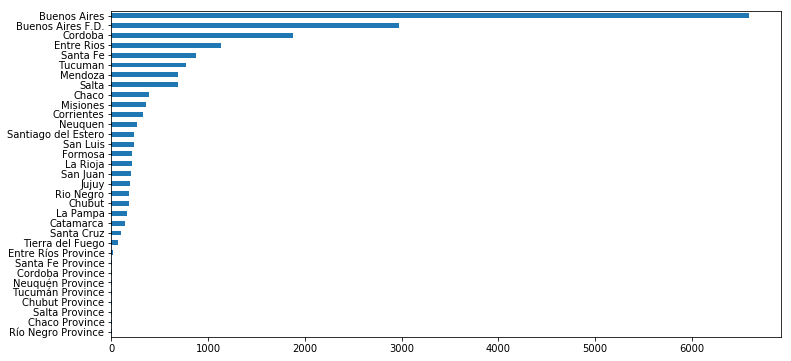

In [ ]:
%matplotlib inline
_= df["country_region"].value_counts().sort_values().plot(kind="barh", figsize = (12,6))

#### Limpio las regiones

En el gráfico anterior, vimos que hay valores que terminan en "Province", con muy pocas observaciones.

Procederemos a limpiar los valores de estas provincias.

In [ ]:
#el siguiente diccionario va a ser usado para limpiar la variable "country_region"
regionDict= {
    "bue":"baires",
    "aires f.d":"caba",
    "cat":"catamarca",
    "chac":"chaco",
    "chub":"chubut",
    "cor":"cordoba",
    "corr":"corrientes",
    "entre":"entre_rios",
    "form":"formosa",
    "juj":"jujuy",
    "pamp":"la_pampa",
    "rioj":"la_rioja",
    "mend":"mendoza",
    "mision":"misiones",
    "neuq":"neuquen",
    "negro":"rio_negro",
    "salt":"salta",
    "juan":"san_juan",
    "luis":"san_luis",
    "cruz":"santa_cruz",
    "santa fe":"santa_fe",
    "santiago":"santiago",
    "fuego":"tierra_del_fuego",
    "tucu":"tucuman"
}

In [ ]:
from nltk.tokenize import RegexpTokenizer

In [ ]:
df["normalized_region"] = df.loc[:,"country_region"]

In [ ]:
#itero sobre el diccionario creado anteriormente, para limpiar las provincias usando sus key/value pairs
#junto con expresiones regulares
for k in regionDict.keys():
    #print(k)
    tokenizer =RegexpTokenizer(k)
    index = df["country_region"].str.lower().apply(lambda x:len(tokenizer.tokenize(x))>0)
    #print(regionDict[k])
    df.loc[index,["normalized_region"]] = regionDict[k]

In [ ]:
installs_by_region = pd.DataFrame(df["normalized_region"].value_counts())
installs_by_region = installs_by_region.rename(columns= {"normalized_region":"number_of_installs"})
installs_by_region["cumpercentage"] =  installs_by_region["number_of_installs"].cumsum()/installs_by_region["number_of_installs"].sum()*100

In [ ]:
installs_by_region.head()

,number_of_installs,cumpercentage
baires,6592,34.576449
caba,2974,50.175715
cordoba,1875,60.010490
entre_rios,1151,66.047731
santa_fe,871,70.616313


Graficaremos un pareto para entender que provincias son las que aportan el mayor número de usuarios.

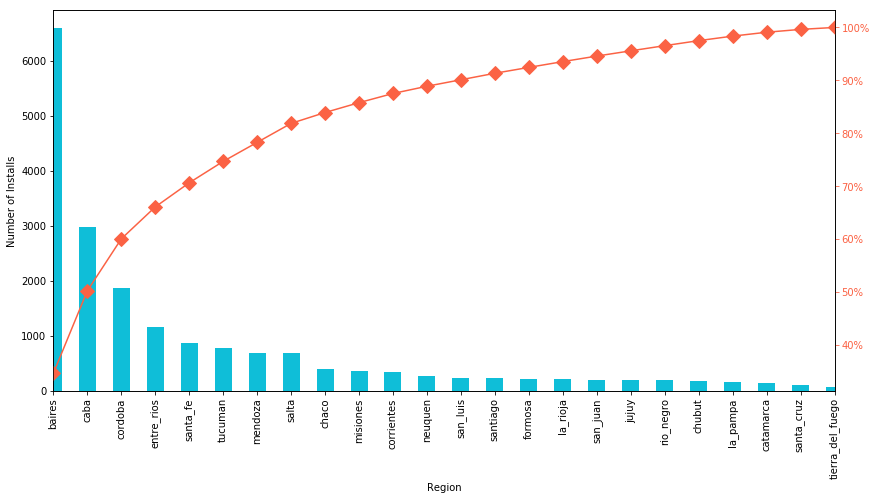

In [ ]:
from matplotlib.ticker import PercentFormatter
fig, ax = plt.subplots(figsize = (14,7))
installs_by_region["number_of_installs"].plot(kind="bar",ax = ax, color="#0FBED8")

ax2 = ax.twinx()
installs_by_region["cumpercentage"].plot(ax = ax2, color="#FB6244", marker="D", ms=10)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.grid(False)
ax.set_xlabel("Region")
ax.set_ylabel("Number of Installs")
ax.tick_params(axis="y")
ax2.tick_params(axis="y", colors="#FB6244")

plt.savefig('pareto_provincias_installs.png')

#### Exploro el churn por provincia

In [ ]:
pd.crosstab(df["normalized_region"], df["target_churn_indicator"], dropna=False).head(2)

target_churn_indicator,0,1
normalized_region,,
baires,2972,3620
caba,1477,1497


In [ ]:
churn_by_region = pd.crosstab(df["normalized_region"], df["target_churn_indicator"], dropna=False)
churn_by_region.columns = ["no", "yes"]
churn_by_region["churn_rate"] = churn_by_region["yes"]/churn_by_region.sum(axis=1)

In [ ]:
churn_by_region["installs"] = churn_by_region["no"]+churn_by_region["yes"]

In [ ]:
churn_by_region.sort_values(by="installs", ascending=False).head()

,no,yes,churn_rate,installs
normalized_region,,,,
baires,2972,3620,0.549150,6592
caba,1477,1497,0.503362,2974
cordoba,922,953,0.508267,1875
entre_rios,513,638,0.554301,1151
santa_fe,404,467,0.536165,871


Del gráfico anterior sabemos que Buenos Aires, CABA,Córdoba, Entre Ríos y Santa Fe, son las provincias con el mayor número de descargas.

De estos top 5, CABA y Córdoba son las provincias con menor "churn rate".

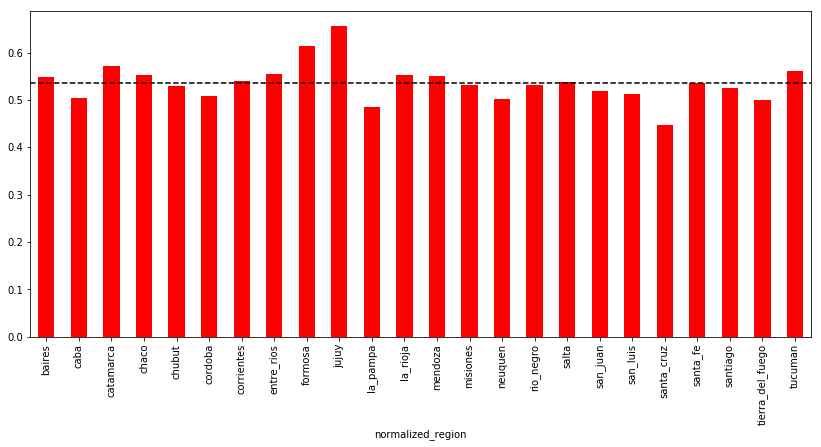

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
_=churn_by_region["churn_rate"].plot(kind="bar", figsize = (14,6), color="red")
_=ax.axhline(df["target_churn_indicator"].mean(), color="black", linestyle="--")
plt.savefig('churnrate_por_ciudad.png')

### Min Max Age

Previamente observamos que las variables <code>min_age_range</code> y <code>max_age_range</code> no sólo estaban correlacionadas, sino que también tenían valores "raros" en los que la edad mínima parecía ser mayor a la edad máxima

Por último, también observamos que era posible modelarlas como variables discretas.

In [ ]:
import seaborn as sns

In [ ]:
# creo un dataframe para "apilar" las edades mínimas sobre las máximas
age_df = pd.DataFrame(np.empty(df.shape[0]*2), columns =["min_max_age"])
age_df["age_range"] = pd.concat([df["max_age_range"],df["min_age_range"]],ignore_index=True)

In [ ]:
age_df.loc[:df.shape[0],["min_max_age"] ] = "max"
age_df.loc[df.shape[0]:,["min_max_age"] ] = "min"

In [ ]:
age_df["age_range"].shape

(38130,)

In [ ]:
age_df.describe()

,age_range
count,38130.000000
mean,17.516575
std,2.418912
min,13.000000
25%,17.000000
50%,18.000000
75%,20.000000
max,21.000000


En el siguiente gráfico, muestra la existencia de valores potentialmente erróneos.

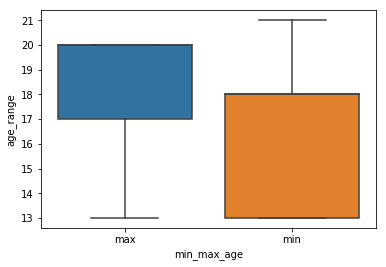

In [ ]:
_=sns.boxplot("min_max_age", "age_range", data=age_df)

#### Limpio valores erróneos

In [ ]:
# identifico los valores en los que "min_age_range" es superior a "max_age_range"
index = df["min_age_range"] > df["max_age_range"]

In [ ]:
min_max_erroneos = df[index]

In [ ]:
min_max_erroneos.shape

(15, 18)

In [ ]:
#invierto los valores erróneos
df.at[min_max_erroneos.index, 'min_age_range'] = min_max_erroneos.max_age_range
df.at[min_max_erroneos.index, 'max_age_range'] = min_max_erroneos.min_age_range

In [ ]:
df[["min_age_range","max_age_range"]].describe()

,min_age_range,max_age_range
count,19065.000000,19065.000000
mean,16.146079,18.887071
std,2.416852,1.450756
min,13.000000,13.000000
25%,13.000000,17.000000
50%,18.000000,20.000000
75%,18.000000,20.000000
max,20.000000,21.000000


#### Creo una variable discreta para capturar la edad de los usuarios

Creo una variable <code>adulto</code>, para capturar si los usuarios poseen un máximo de edad mayor a 17 (adultos) o no.

In [ ]:
df["adulto"] = df["max_age_range"].apply(lambda x: 1 if x >17 else 0)

Un 63% de los usuarios, son adultos.

In [ ]:
df["adulto"].value_counts()/df.shape[0]

1    0.628901
0    0.371099
Name: adulto, dtype: float64

In [ ]:
pd.crosstab(df["adulto"], df["target_churn_indicator"])

target_churn_indicator,0,1
adulto,,
0,3103,3972
1,5740,6250


In [ ]:
#crea el dataframe con las horas y el "count" de la variable de respuesta
churn_by_age = pd.crosstab(df["adulto"], df["target_churn_indicator"])
churn_by_age.columns = ["no", "yes"]
#creo una variable para capturar el "churn rate" por hora
churn_by_age["churn_rate"] = churn_by_age["yes"]/churn_by_age.sum(axis=1)

In [ ]:
churn_by_age

,no,yes,churn_rate
adulto,,,
0,3103,3972,0.561413
1,5740,6250,0.521268


In [ ]:
total_adult_minor = df["adulto"].value_counts().tolist()

In [ ]:
total_adult_minor_per = (df["adulto"].value_counts()/df.shape[0]).tolist()

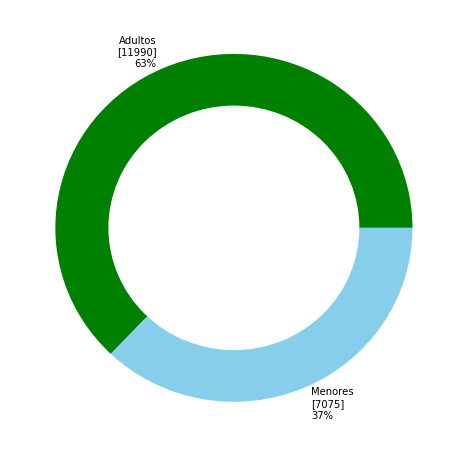

In [ ]:
# creo labels
names=["Adultos\n[{}]\n{:.0f}%".format(total_adult_minor[0], total_adult_minor_per[0]*100),
       "Menores\n[{}]\n{:.0f}%".format(total_adult_minor[1], total_adult_minor_per[1]*100)]
size_of_groups=total_adult_minor

fix, ax = plt.subplots(figsize = (8,8))
# creo el pieplot
plt.pie(size_of_groups, labels=names, colors=['green','skyblue'])

 
# círculo blanco en el centro
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
 
plt.show()

Los adultos parecen tener una tasa de "churn" menor a los menores de edad, y ligeramente menor a la media.

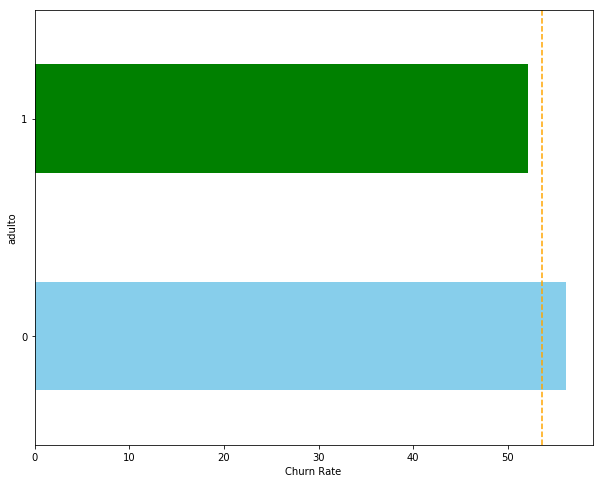

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
_=churn_by_age["churn_rate"].plot(kind="barh", figsize = (10,8), color=['skyblue','green'])
_=ax.axvline(df["target_churn_indicator"].mean(), color="orange", linestyle="--")
_=plt.xlabel("Churn Rate")
plt.xticks(np.arange(0,.55,.1),np.arange(0,55,10) )
plt.savefig('churnrate_por_edad.png')

#### Genero vs churn

Exploraremos como varía el "churn" en base al género de los usuarios.

In [ ]:
pd.crosstab(df["gender"], df["target_churn_indicator"])

target_churn_indicator,0,1
gender,,
female,4921,5404
male,3836,4740
unknown,86,78


In [ ]:
#crea el dataframe con las horas y el "count" de la variable de respuesta
churn_by_gender = pd.crosstab(df["gender"], df["target_churn_indicator"])
churn_by_gender.columns = ["no", "yes"]
#creo una variable para capturar el "churn rate" por hora
churn_by_gender["churn_rate"] = churn_by_gender["yes"]/churn_by_gender.sum(axis=1)

In [ ]:
churn_by_gender

,no,yes,churn_rate
gender,,,
female,4921,5404,0.523390
male,3836,4740,0.552705
unknown,86,78,0.475610


In [ ]:
total_fem_male_unk = df["gender"].value_counts().tolist()
total_fem_male_unk_per = (df["gender"].value_counts()/df.shape[0]).tolist()

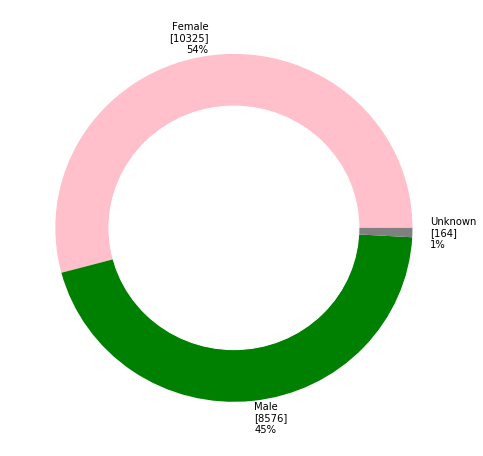

In [ ]:
# creo labels
names=["Female\n[{}]\n{:.0f}%".format(total_fem_male_unk[0], total_fem_male_unk_per[0]*100),
       "Male\n[{}]\n{:.0f}%".format(total_fem_male_unk[1], total_fem_male_unk_per[1]*100),
      "Unknown\n[{}]\n{:.0f}%".format(total_fem_male_unk[2], total_fem_male_unk_per[2]*100)]
size_of_groups=total_fem_male_unk

fix, ax = plt.subplots(figsize = (8,8))
# pieplot
plt.pie(size_of_groups, labels=names, colors=['pink','green','grey'])
#
 
# círculo en el medio
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
 
plt.show()

Observamos que hay una mayor proporción de mujeres usando la aplicación, y que este grupo tiene una tasa de "churn" ligeramente menor a la de los hombres.

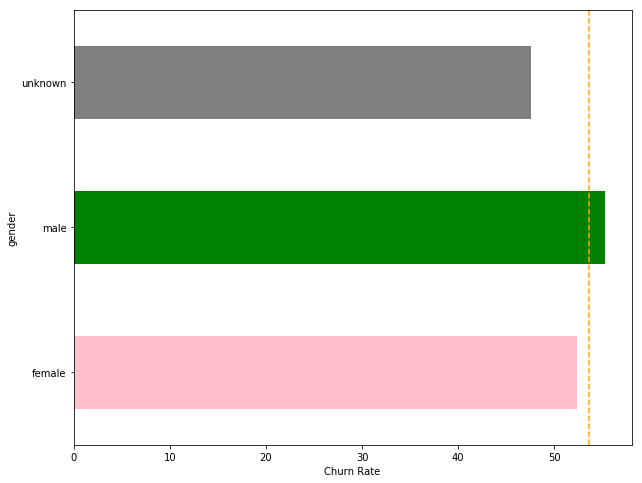

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
_=churn_by_gender["churn_rate"].plot(kind="barh", figsize = (10,8), color=['pink','green','grey'])
_=ax.axvline(df["target_churn_indicator"].mean(), color="orange", linestyle="--")
_=plt.xlabel("Churn Rate")
plt.xticks(np.arange(0,.55,.1),np.arange(0,55,10) )
plt.savefig('churnrate_por_edad.png')

### Eventos

Si bien los eventos estan anonimizados, es probable que los mismos estén asociados a la tasa de "churn.

Un mayor número de eventos, equivale a un mayor nivel de "engagement" del usuario con la aplicación?

Primero voy a discretizar los eventos usando <code>qcut</code> y <code>cut</code>

In [ ]:
df["E1_cut"] = pd.qcut(df["event_1"],10)
df["E2_cut"] = pd.qcut(df["event_2"],10)

# los eventos 3-5 tienen muchos valores cercanos a 0, lo que causaba un error de quantiles duplicados
#por eso decidí usar la funcitón "cut", ya que mi objetivo es explorar la relación entre churno y los valores
#de los eventos
df["E3_cut"] = pd.cut(df["event_3"],10)
df["E4_cut"] = pd.cut(df["event_4"],10)
df["E5_cut"] = pd.cut(df["event_5"],10)

In [ ]:
ev1_churn = pd.concat([df[["E1_cut", "target_churn_indicator"]].groupby("E1_cut").count(),
           df[["E1_cut", "target_churn_indicator"]].groupby("E1_cut").mean()], axis=1)

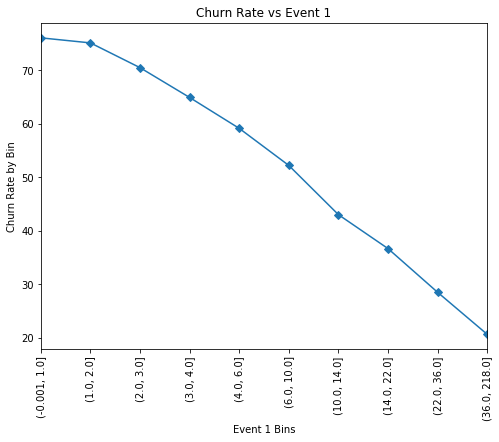

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
_=ev1_churn.iloc[:,1].plot(marker="D")
_=plt.yticks(np.arange(0.2,.75,.1),np.arange(20,75,10))
_=plt.xticks(rotation = 90)
ax.set_xlabel("Event 1 Bins")
ax.set_ylabel("Churn Rate by Bin")
plt.title("Churn Rate vs Event 1")
plt.savefig('evento1_vs_churn_rate.png')

In [ ]:
ev2_churn = pd.concat([df[["E2_cut", "target_churn_indicator"]].groupby("E2_cut").count(),
           df[["E2_cut", "target_churn_indicator"]].groupby("E2_cut").mean()], axis=1)

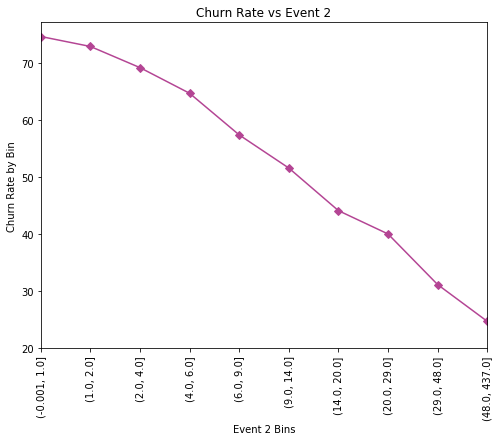

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
_=ev2_churn.iloc[:,1].plot(marker="D", color ="#B44594")
_=plt.yticks(np.arange(0.2,.75,.1),np.arange(20,75,10))
_=plt.xticks(rotation = 90)
ax.set_xlabel("Event 2 Bins")
ax.set_ylabel("Churn Rate by Bin")
plt.title("Churn Rate vs Event 2")
plt.savefig('evento2_vs_churn_rate.png')

In [ ]:
pd.concat([df[["E3_cut", "target_churn_indicator"]].groupby("E3_cut").count(),
           df[["E3_cut", "target_churn_indicator"]].groupby("E3_cut").mean()], axis=1)

,target_churn_indicator,target_churn_indicator
E3_cut,,
"(-0.02, 2.0]",17818,0.558256
"(2.0, 4.0]",867,0.242215
"(4.0, 6.0]",243,0.189300
"(6.0, 8.0]",88,0.170455
"(8.0, 10.0]",25,0.040000
"(10.0, 12.0]",15,0.133333
"(12.0, 14.0]",3,0.000000
"(14.0, 16.0]",2,0.000000
"(16.0, 18.0]",2,0.000000


In [ ]:
pd.concat([df[["E4_cut", "target_churn_indicator"]].groupby("E4_cut").count(),
           df[["E4_cut", "target_churn_indicator"]].groupby("E4_cut").mean()], axis=1)

,target_churn_indicator,target_churn_indicator
E4_cut,,
"(-0.056, 5.6]",13970,0.638368
"(5.6, 11.2]",3696,0.285985
"(11.2, 16.8]",942,0.188960
"(16.8, 22.4]",353,0.144476
"(22.4, 28.0]",91,0.175824
"(28.0, 33.6]",9,0.222222
"(33.6, 39.2]",2,0.000000
"(39.2, 44.8]",1,0.000000
"(44.8, 50.4]",0,NaN


In [ ]:
pd.concat([df[["E5_cut", "target_churn_indicator"]].groupby("E5_cut").count(),
           df[["E5_cut", "target_churn_indicator"]].groupby("E5_cut").mean()], axis=1)

,target_churn_indicator,target_churn_indicator
E5_cut,,
"(-0.064, 6.4]",15130,0.589623
"(6.4, 12.8]",2817,0.357827
"(12.8, 19.2]",831,0.265945
"(19.2, 25.6]",185,0.254054
"(25.6, 32.0]",78,0.230769
"(32.0, 38.4]",11,0.272727
"(38.4, 44.8]",6,0.166667
"(44.8, 51.2]",6,0.333333
"(51.2, 57.6]",0,NaN


Vemos que en todos los casos, en promedio, a mayor número de Eventos, menor tasa de "churn".<br>
Esta tendendencia no tiene la misma fuerza ni variabilidad en los distintos eventos.<br>

Por último, voy a crear un variable que me indica la cantidad de eventos activos por usuario (donde activo es cualquier evento con un valor mayor a 0.

In [ ]:
df["number_of_events"] = (df.iloc[:,8:13]>0).sum(axis=1)

In [ ]:
churn_by_number_of_ev = pd.concat([df[["number_of_events","target_churn_indicator"]].groupby("number_of_events").count(),
           df[["number_of_events","target_churn_indicator"]].groupby("number_of_events").mean()], axis=1)

La gran mayoría de los usuarios participaron en 4 tipos de eventos.<br>
Los usuarios que participaron en los 5 eventos, parecen tener una "churn rate" mucho menor a la media.

In [ ]:
churn_by_number_of_ev.columns = ["cantidad_de_usuarios", "churn_rate"]
churn_by_number_of_ev

,cantidad_de_usuarios,churn_rate
number_of_events,,
0,4,0.250000
1,629,0.715421
2,721,0.760055
3,883,0.557191
4,12039,0.610682
5,4789,0.287952


Para modelar la clasificación de "churn"/"no churn", voy a crear modelos de "ensamble" y árboles ya que deberían ser capaces de captar la interacción entre todas las variables del dataset.

### Usuarios Repetidos

El "pdf" que viene junto con el dataset describe a la variable <code>user_id"</code> como "identificador unívoco anonimizado del usuario.".

In [ ]:
len(df["user_id"].unique())

17689

In [ ]:
df_backup = df.copy()

In [ ]:
df = df.sort_values(by = "install_time")
df.reset_index(drop=True, inplace=True)

In [ ]:
df_backup.head(2)

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,...,install_hour,am_7_8,normalized_region,adulto,E1_cut,E2_cut,E3_cut,E4_cut,E5_cut,number_of_events
0,2ba6f357,2018-07-04 19:24:24,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,...,19,0,santa_cruz,0,"(-0.001, 1.0]","(1.0, 2.0]","(-0.02, 2.0]","(-0.056, 5.6]","(-0.064, 6.4]",4
1,3cb936c1,2018-06-30 13:41:29,Android,Corrientes,Corrientes,male,13,17,0,7,...,13,0,corrientes,0,"(-0.001, 1.0]","(6.0, 9.0]","(-0.02, 2.0]","(-0.056, 5.6]","(-0.064, 6.4]",2


In [ ]:
df.head(2)

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,...,install_hour,am_7_8,normalized_region,adulto,E1_cut,E2_cut,E3_cut,E4_cut,E5_cut,number_of_events
0,c6a9eb2a,2018-06-30 00:00:36,Android,Buenos Aires F.D.,Buenos Aires,female,18,20,32,34,...,0,0,caba,1,"(22.0, 36.0]","(29.0, 48.0]","(-0.02, 2.0]","(5.6, 11.2]","(6.4, 12.8]",5
1,80fc4d12,2018-06-30 00:01:41,Android,Buenos Aires,Merlo,female,18,20,33,31,...,0,0,baires,1,"(22.0, 36.0]","(29.0, 48.0]","(-0.02, 2.0]","(-0.056, 5.6]","(6.4, 12.8]",4


Voy a explorar usuarios que aparezcan más de una vez en el dataset.

In [ ]:
df["dummy"]=1

In [ ]:
df["loyalty"] = df[["user_id","dummy"]].groupby("user_id").cumsum()

In [ ]:
dups = df[df["loyalty"] >1]

In [ ]:
dups.shape

(1376, 27)

El churn rate de estos usuarios es mucho menor a la media.

In [ ]:
dups["target_churn_indicator"].mean()

0.3066860465116279

In [ ]:
first_10 = dups["user_id"][:10]
last_10 = dups["user_id"][-10:]

In [ ]:
dup_ids = pd.concat([first_10,last_10])

In [ ]:
index = df["user_id"].apply(lambda x: np.isin(x,dup_ids))

Al explorar los primeros y últimos 10 usuarios duplicados, veo que la hora de instalación para los duplicados es la misma pero cambian algunas variables. En algunos casos el mismo usuario instaló la app a la misma hora, estando ubicado en distintas provincias.<br>
Esto puede darse por algún error raro, pero voy a asumir que algunas observaciones del dataset, fueron generadas con muestreo por reemplazo, y luego se alteraron algunas variables con el fin de aumentar la cantidad de observaciones.

Esta última teoría esta respaldada en el echo de que aparentement, los usuarios duplicados poseen el mismo valor en la variable "target_churn_indicator".

In [ ]:
df.loc[index, ["user_id","install_time",'country_region','event_3', 'event_4', 'event_5',"target_churn_indicator"]]

,user_id,install_time,country_region,event_3,event_4,event_5,target_churn_indicator
8,77424ded,2018-06-30 00:04:42,Buenos Aires,1,2,0,1
9,77424ded,2018-06-30 00:04:42,Buenos Aires,0,2,2,1
11,53e01855,2018-06-30 00:05:12,Buenos Aires F.D.,0,0,0,1
12,53e01855,2018-06-30 00:05:12,Catamarca,6,9,25,1
16,a2ea323b,2018-06-30 00:06:18,Buenos Aires,0,5,4,1
17,a2ea323b,2018-06-30 00:06:18,Buenos Aires F.D.,6,13,5,1
81,7fb48b68,2018-06-30 00:32:45,Buenos Aires F.D.,0,1,0,1
82,7fb48b68,2018-06-30 00:32:45,Tierra del Fuego,1,11,8,1
141,2e9bbf7,2018-06-30 00:55:12,Buenos Aires,0,1,3,1
142,2e9bbf7,2018-06-30 00:55:12,Buenos Aires,1,3,7,1


Si fuese una competencia (i.e estilo Kaggle), usaría los usuarios repetidos para incrementar el accuracy de los modelos, ya que tienen una tasa menor de "churn rate".

En este contexto, no voy a usar la variable "loyalty", ya que sería usada para clasificar observaciones en "no churn" y de la misma manera que asumo que la gran cantidad de "churns" puesta el día "Sábado" fue hecha a propósito, interpreto que en este caso, los duplicados con mismo valor de "target_churn_indicator" son producto de un muestreo con reemplazo.

Nuevamente, he decidido NO explotar el hecho de que haya usuarios repetidos con el mismo valor en la variable "target_churn_indicator"

### Encoding y Selección de variables

Selecciono un grupo inicial de variables para remover, debido a que:

1. No aportan valor predictivo (i.e user_id).
2. Se crearon otras variables que las reemplazan (i.e install_time fue reemplazada por 'day' e 'install_hour', min/max age range fueron reemplazadas por la variable "adulto")

**Nota**: sería interesante estudiar la variable "city", pero por cuestiones de tiempo, decidí dejarla fuera de este proyecto.

Ya vimos que cada observación no representa a un usuario, sino que hay usuarios que aparecen mas de una vez.

Voy a remover esta ID, para crear un índice único (si fuera un competencia, explotaría esta variable).

In [ ]:
df = df_backup.copy()

In [ ]:
df.head()

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,...,install_hour,am_7_8,normalized_region,adulto,E1_cut,E2_cut,E3_cut,E4_cut,E5_cut,number_of_events
0,2ba6f357,2018-07-04 19:24:24,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,...,19,0,santa_cruz,0,"(-0.001, 1.0]","(1.0, 2.0]","(-0.02, 2.0]","(-0.056, 5.6]","(-0.064, 6.4]",4
1,3cb936c1,2018-06-30 13:41:29,Android,Corrientes,Corrientes,male,13,17,0,7,...,13,0,corrientes,0,"(-0.001, 1.0]","(6.0, 9.0]","(-0.02, 2.0]","(-0.056, 5.6]","(-0.064, 6.4]",2
2,17d88bbc,2018-06-30 16:02:30,Android,Cordoba,Villa Carlos Paz,female,18,20,2,1,...,16,0,cordoba,1,"(1.0, 2.0]","(-0.001, 1.0]","(-0.02, 2.0]","(-0.056, 5.6]","(-0.064, 6.4]",4
3,7baa10b6,2018-07-02 21:08:33,Android,Buenos Aires,Don Torcuato,female,13,17,5,6,...,21,0,baires,0,"(4.0, 6.0]","(4.0, 6.0]","(-0.02, 2.0]","(-0.056, 5.6]","(-0.064, 6.4]",4
4,120d379,2018-07-07 04:18:47,Android,Santiago del Estero,Santiago del Estero,female,13,17,8,12,...,4,0,santiago,0,"(6.0, 10.0]","(9.0, 14.0]","(-0.02, 2.0]","(-0.056, 5.6]","(-0.064, 6.4]",4


In [ ]:
drop = ["user_id", 'install_time','country_region', 'city']

In [ ]:
y = df["target_churn_indicator"]

In [ ]:
df_reduced = df.drop(columns=drop)

In [ ]:
df_reduced.dtypes

platform                    object
gender                      object
min_age_range                int64
max_age_range                int64
event_1                      int64
event_2                      int64
event_3                      int64
event_4                      int64
event_5                      int64
target_churn_indicator       int64
day                         object
install_hour                 int64
am_7_8                       int64
normalized_region           object
adulto                       int64
E1_cut                    category
E2_cut                    category
E3_cut                    category
E4_cut                    category
E5_cut                    category
number_of_events             int64
dtype: object

#### Encoding

In [ ]:
#me quedo con las variabels categóricas por un lado
categorical_df = df_reduced.select_dtypes(include='object')
#y las numéricas por otro
numeric_df = df_reduced.select_dtypes(include=['int32','int64'])

In [ ]:
#importo librería 
from sklearn.preprocessing import OneHotEncoder

**Nota**: si bien podría usar <code>LabelEncoder</code> para las variables binarias, prefiero usar "onehot" en combinación con una función 'custom' para que la tarea de encoding sea mas automática.

In [ ]:
def encode_categories(catDF):
    #Note: requires OneHotEncoder to be previously loaded in the workspace
    #Encodes all categorical variables of a given dataset.
    
    #Input
    # catDF: a data frame with only cateogrical features
    #Output
    # An encoded dataframe with numerical features
    one = OneHotEncoder(sparse=False)

    one.fit(catDF)

    colNames = []

    for i in range(0, len(catDF.columns)):
        colNames.extend((catDF.columns[i] + "_" + one.categories_[i]).tolist())
        
    return pd.DataFrame(one.transform(catDF), columns = colNames)

In [ ]:
#encodeo las variables categóricas
catDF_trx = encode_categories(categorical_df)

In [ ]:
catDF_trx.set_index(df.index, inplace=True)

In [ ]:
catDF_trx.shape

(19065, 36)

In [ ]:
numeric_df.shape

(19065, 12)

In [ ]:
numeric_df.describe()

,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,install_hour,am_7_8,adulto,number_of_events
count,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000,19065.000000
mean,16.146079,18.887071,13.887857,18.931130,0.534487,4.378862,4.465355,0.536166,12.289011,0.023131,0.628901,4.029426
std,2.416852,1.450756,19.148217,27.096516,1.254818,4.241902,4.509056,0.498703,8.246541,0.150325,0.483112,0.865010
min,13.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,17.000000,2.000000,3.000000,0.000000,1.000000,2.000000,0.000000,3.000000,0.000000,0.000000,4.000000
50%,18.000000,20.000000,6.000000,9.000000,0.000000,3.000000,3.000000,1.000000,15.000000,0.000000,1.000000,4.000000
75%,18.000000,20.000000,18.000000,24.000000,1.000000,6.000000,6.000000,1.000000,20.000000,0.000000,1.000000,5.000000
max,20.000000,21.000000,218.000000,437.000000,20.000000,56.000000,64.000000,1.000000,23.000000,1.000000,1.000000,5.000000


In [ ]:
#me aseguro de que lo indices de ambos dataframes sean iguales para evitar problemas con el 'merge'
catDF_trx.set_index(numeric_df.index, inplace=True)

In [ ]:
#uno los dataframes categóricos y numéricos
predictors = catDF_trx.merge(numeric_df, left_index=True, right_index =True)

In [ ]:
predictors.shape

(19065, 48)

#### Baseline data frame

Suelo usar un "baseline dataframe" sin ingeniería de atributos, para entender el impacto de esta actividad.
Voy a remover las variables creadas a partir de "install_time" y "min/max_age_range".

In [ ]:
drop_eng = ["install_hour","am_7_8","adulto",'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu',
       'day_tue', 'day_wed','target_churn_indicator', 'number_of_events']

In [ ]:
baseline_predictors = predictors.drop(columns = drop_eng)

In [ ]:
baseline_predictors.head(2)

,platform_Android,platform_iOS,gender_female,gender_male,gender_unknown,normalized_region_baires,normalized_region_caba,normalized_region_catamarca,normalized_region_chaco,normalized_region_chubut,...,normalized_region_santiago,normalized_region_tierra_del_fuego,normalized_region_tucuman,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,13,17,1,2,0,1,1
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,13,17,0,7,0,3,0


#### Selección de variables: round 2

Ahora quito algunas variables con alta dependencia de los "predictores".

In [ ]:
drop = ['platform_iOS', 'gender_unknown', "target_churn_indicator",'min_age_range', 'max_age_range']
#también podría quitar un día y una region, pero prefiero no hacerlo por un tema de interpretabilidad
# en el caso de "platform_Android", se que el 0 significa que la plataforma es "iOS", como también se que si
# male y female son 0, entonces el gender es "unknown"

In [ ]:
predictors = predictors.drop(columns=drop)

In [ ]:
predictors.shape

(19065, 43)

## Modelado

El objetivo será construir un modelo que prediga el "churn" de usuarios.<br>
La métrica **"recall"** va a ser usada para definir la performance de los modelos.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost
from sklearn.metrics import accuracy_score

In [ ]:
seed = 1501 #seed forall random processes

In [ ]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(baseline_predictors, y, test_size=.3, random_state=seed)

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(predictors, y, test_size=.10, random_state=seed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.20, random_state=seed)

### Funciones de reporte y análisis

In [ ]:
def plot_conf_mat(model,predictorMat, responseVar, percent=True):
    _=fig, ax = plt.subplots(figsize=(14,5), dpi=100)
    _=cm_viz = classifier.ConfusionMatrix(model, percent=percent)
    _=cm_viz.score(predictorMat, responseVar)
    _=cm_viz.poof()

In [ ]:
def plot_class_report(model,predictorMat, responseVar):
    _=fig, ax = plt.subplots(figsize=(14,5), dpi=100)
    _=cm_viz = classifier.ClassificationReport(model, ax=ax)
    _=cm_viz.score(predictorMat, responseVar)
    _=cm_viz.poof()

In [ ]:
def plot_param_effect(model_instance, param_name, param_range, scoring="accuracy"):
    fig, ax = plt.subplots(figsize=(14,5))
    vc_viz = ms.ValidationCurve(model_instance(random_state=seed), 
        n_jobs=-1, ax=ax, param_name=param_name,
                                scoring=scoring,
        param_range=param_range)
    vc_viz.fit(X_train, y_train)
    vc_viz.poof()

In [ ]:
def Find_Optimal_Cutoff(target, predicted):
    """ Ecuentra la probabilidad optima de corte comporando la sensitividad y espeficidad del modelo
    Inputs
    ----------
    target : vector con las clasificacionoes reales de la variable dependiente (la que me interesa predecir)

    predicted : vector con mis predicciones

    Returns
    -------     
    Una lista con el valor óptimo de corte. Este valor óptimo, busca minimizar la diferencia absoluta entre la
    sensitividad y espeficidad

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    # en la siguiente líne de código cuando evalúa 'tpr-(1-fpr)', es lo mismo que "sensitivity - specificity (o True Negative Rate)
    roc = pd.DataFrame({'delta' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.delta).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

### Modelos baseline

#### Baseline data frame vs ingenieria de atributos

In [ ]:
best_model_dict = {}

In [ ]:
from yellowbrick import classifier, features, regressor
import yellowbrick.model_selection as ms
from sklearn import metrics

In [ ]:
seed = 1501

In [ ]:
dt_base_df = DecisionTreeClassifier(max_depth=4, random_state=seed)

In [ ]:
dt_base_df.fit(X_train_base, y_train_base)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1501,
            splitter='best')

In [ ]:
y_train_pred_dt_base = dt_base_df.predict(X_train_base)

In [ ]:
y_test_pred_dt_base = dt_base_df.predict(X_test_base)

In [ ]:
# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_base,y_train_pred_dt_base))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_base, y_test_pred_dt_base))

Accuracy sobre conjunto de Train: 0.6841513675533908
Accuracy sobre conjunto de Test: 0.6917832167832167


In [ ]:
best_model_dict["dt_base_df"] = {"holdout_accuracy": accuracy_score(y_test_base,y_test_pred_dt_base),
                                "holdout_recall": metrics.recall_score(y_test_base,y_test_pred_dt_base),
                                "holdout_precision":metrics.precision_score(y_test_base,y_test_pred_dt_base) }

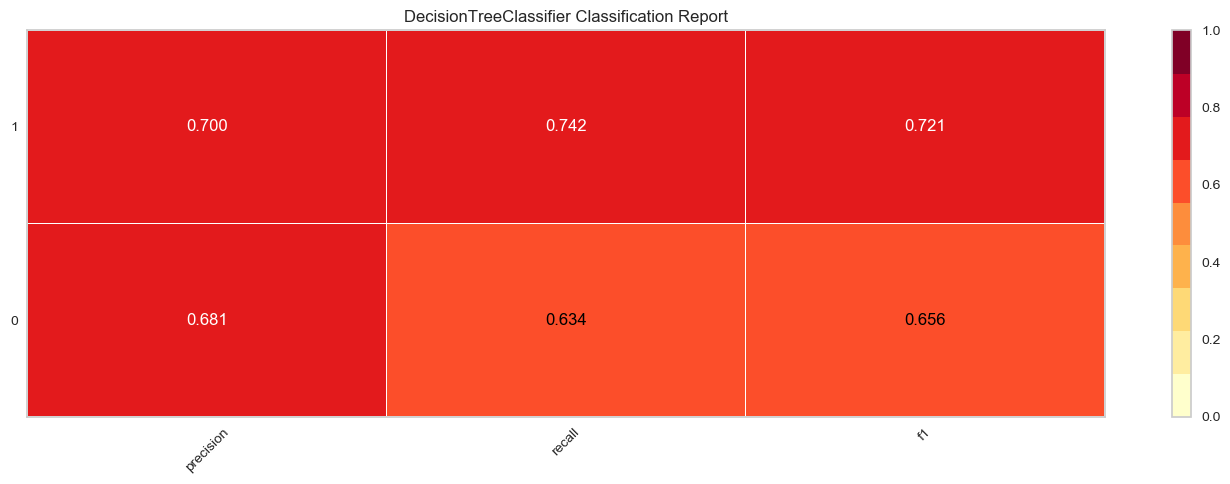

In [ ]:
plot_class_report(dt_base_df, X_test_base, y_test_base)

#### Arbol de Decision (smart baseline)

Vamos a crear un baseline "inteligente", que va a servir de benchmark para los demás modelos.
La idea es instanciar un arbol de clasificación de profundad 4 así evitamos el sobreajuste.

In [ ]:
dt = DecisionTreeClassifier(max_depth=4, random_state = seed)

In [ ]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1501,
            splitter='best')

In [ ]:
y_train_pred_dt = dt.predict(X_train)

In [ ]:
y_test_pred_dt = dt.predict(X_test)

In [ ]:
# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train,y_train_pred_dt))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test,y_test_pred_dt))

Accuracy sobre conjunto de Train: 0.7122249745009471
Accuracy sobre conjunto de Test: 0.708041958041958


In [ ]:
y_hold_pred_dt = dt.predict(X_holdout)

In [ ]:
best_model_dict["dt_eng_df"] = {"holdout_accuracy": accuracy_score(y_holdout,y_hold_pred_dt),
                                "holdout_recall": metrics.recall_score(y_holdout,y_hold_pred_dt),
                                "holdout_precision":metrics.precision_score(y_holdout,y_hold_pred_dt) }

In [ ]:
pd.DataFrame(best_model_dict).T

,holdout_accuracy,holdout_recall,holdout_precision
dt_base_df,0.691783,0.742167,0.700339
dt_eng_df,0.707918,0.750491,0.716026


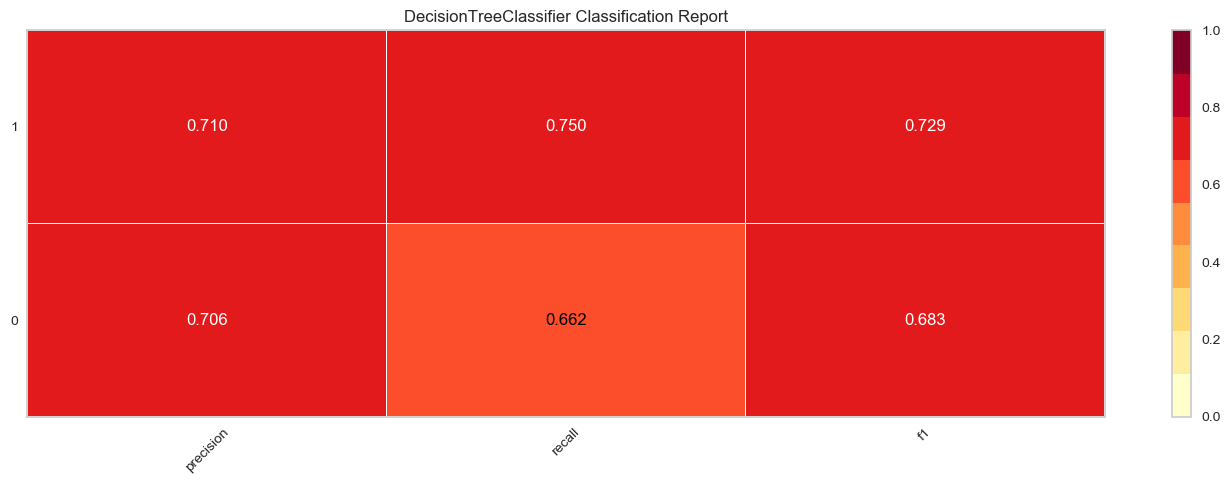

In [ ]:
plot_class_report(dt, X_test, y_test)

### Modelos optimizados

In [ ]:
from sklearn.model_selection import GridSearchCV
import yellowbrick.model_selection as ms

**Nota**: por lo general no uso grid search con modelos de ensemble, salvo que los resultados no sean buenos (i.e que no sean muy superiors al baseline actual, o método actual para un problema de predicción).<br>
En base a mi experiencia, los valores defaults que vienen con los modelos ensemble traen resultados muy similares a los obtenidos mediante el uso de <code>GridSearchCV</code>, y en muchos casos, incluso mejores.

De todas formas voy a usar <code>GridSearchCV</code>, porque asumo que quieren evaluar mi capacidad de usar este método.

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=seed, n_estimators = 250)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=1501, verbose=0,
            warm_start=False)

In [ ]:
y_test_train_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [ ]:
# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_test_train_rf,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred_rf,y_test))

Accuracy sobre conjunto de Train: 0.9984700568264607
Accuracy sobre conjunto de Test: 0.708041958041958


In [ ]:
y_hold_pred_rf = rf.predict(X_holdout)

In [ ]:
best_model_dict["rf_eng_df"] = {"holdout_accuracy": accuracy_score(y_holdout,y_hold_pred_rf),
                                "holdout_recall": metrics.recall_score(y_holdout,y_hold_pred_rf),
                                "holdout_precision":metrics.precision_score(y_holdout,y_hold_pred_rf) }

In [ ]:
pd.DataFrame(best_model_dict).T

,holdout_accuracy,holdout_recall,holdout_precision
dt_base_df,0.691783,0.742167,0.700339
dt_eng_df,0.707918,0.750491,0.716026
rf_eng_df,0.712638,0.755403,0.720037


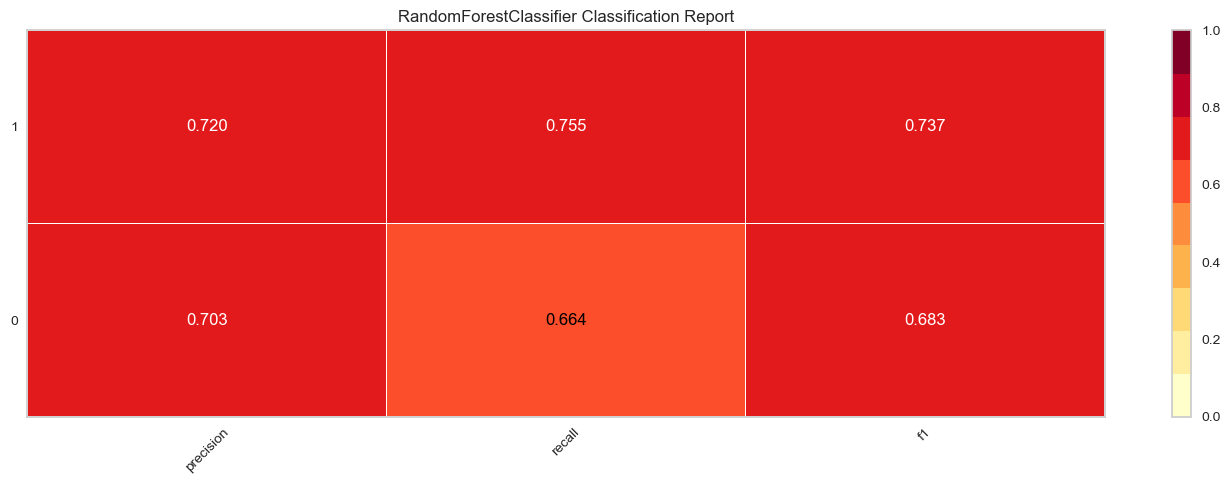

In [ ]:
plot_class_report(rf, X_holdout, y_holdout)

#### Random Forest Grid Search

Vamos a explorar una serie de parámetros con la librería "model_selection" de yellowbrick.

**Nota**: Esto lo hago, porque GridSearch lleva tiempo ya que crece exponencialmente con el número de parámetros y cantidad de valores a probar de los mismos. Esta exploración me permite acotar la cantidad de parámetros y combinaciones de la grilla.

In [1]:
plot_param_effect(RandomForestClassifier, "n_estimators", np.arange(50,1000,100), scoring="recall")

NameError: ignored

In [ ]:
plot_param_effect(RandomForestClassifier, "max_depth", np.arange(2,20,1), scoring="recall")

In [ ]:
plot_param_effect(RandomForestClassifier, "criterion", ["gini", "entropy"], scoring="recall")

In [ ]:
plot_param_effect(RandomForestClassifier, "bootstrap", [True, False], scoring="recall")

In [ ]:
# los valores de la grilla fueron elegidos en base a los resultados de las curvas de validación
grid_forest  ={
    "max_depth": [7, 9, 11, 13, None],
    "criterion": ["gini"],
    "n_estimators": [450, 700, 850],
    "random_state":[seed]
}

In [ ]:
rf_cv = GridSearchCV(rf, grid_forest, scoring="recall",cv = 5)

In [ ]:
rf_cv.fit(X_train, y_train)

In [ ]:
rf_cv.best_params_

In [ ]:
rf_best = XGBClassifier(**rf_cv.best_params_)
rf_best.fit(X_train, y_train, eval_set=[(X_test, y_test)] ) 

In [ ]:
y_train_pred_rf_best = rf_best.predict(X_train)
y_test_pred_rf_best = rf_best.predict(X_test)

In [ ]:
# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred_rf_best,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred_rf_best,y_test))

In [ ]:
y_hold_pred_rf_grid = rf_best.predict(X_holdout)

In [ ]:
best_model_dict["rf_grid_eng_df"] = {"holdout_accuracy": accuracy_score(y_holdout,y_hold_pred_rf_grid),
                                "holdout_recall": metrics.recall_score(y_holdout,y_hold_pred_rf_grid),
                                "holdout_precision":metrics.precision_score(y_holdout,y_hold_pred_rf_grid) }

In [ ]:
pd.DataFrame(best_model_dict).T

In [ ]:
plot_class_report(rf_best, X_holdout, y_holdout)

### XGB

In [ ]:
xgb = XGBClassifier(max_depth = 2, n_estimators=50, random_state=seed)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=50, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=1501, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [ ]:
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

In [ ]:
# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred_xgb,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred_xgb,y_test))

Accuracy sobre conjunto de Train: 0.7274515517995046
Accuracy sobre conjunto de Test: 0.7173659673659674


In [ ]:
y_hold_pred_xgb = xgb.predict(X_holdout)

In [ ]:
best_model_dict["xgb_eng_df"] = {"holdout_accuracy": accuracy_score(y_holdout,y_hold_pred_xgb),
                                "holdout_recall": metrics.recall_score(y_holdout,y_hold_pred_xgb),
                                "holdout_precision":metrics.precision_score(y_holdout,y_hold_pred_xgb) }

In [ ]:
metrics.recall_score(y_holdout,y_hold_pred_xgb, average="binary")

0.8055009823182712

In [ ]:
pd.DataFrame(best_model_dict).T

,holdout_accuracy,holdout_recall,holdout_precision
dt_base_df,0.691783,0.742167,0.700339
dt_eng_df,0.707918,0.750491,0.716026
rf_eng_df,0.712638,0.755403,0.720037
rf_grid_eng_df,0.683272,0.705305,0.702544
xgb_eng_df,0.723650,0.805501,0.713664


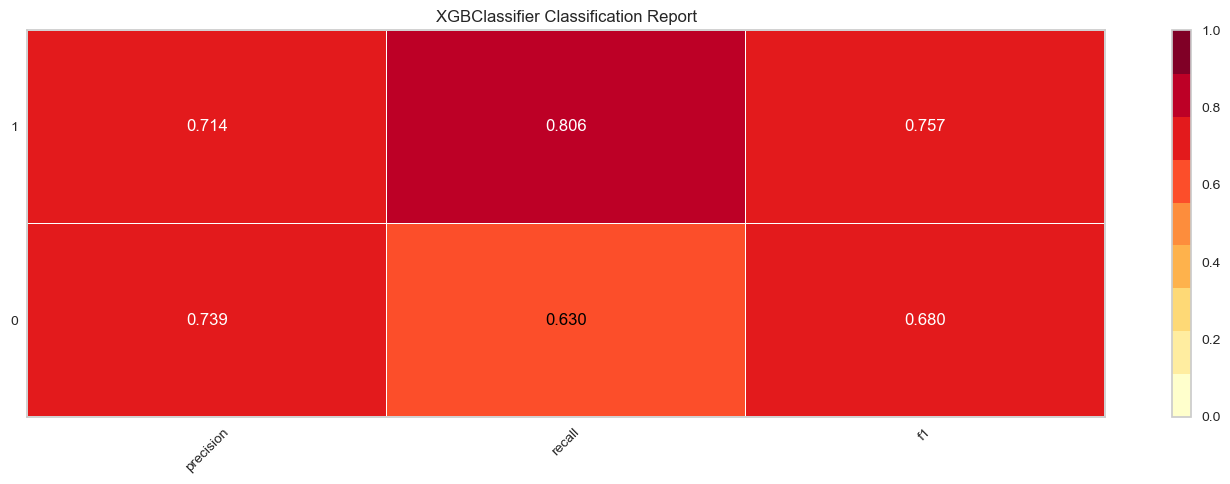

In [ ]:
plot_class_report(xgb, X_holdout, y_holdout)

#### XGBoost GridSearch

Antes de correr 'gridsearch', voy a explorar el impact de que tienend distinos valores de hyperparámetros que suelo usar para modelar:

1. <code>alpha</code>: elimina variables que no son importantes por ser esparsas (cuando puede).
2. <code>n_estimators</code>: cantidad de árboles.
3. <code>max_depth</code>: elimina variables que no son importantes por ser esparsas (cuando puede).
4. <code>colsample_bytree</code>: porcentaje de columnas usadas en cada boosting round.
5. <code>learning_rate</code>: vuelve cada step de boosting mas conservador

C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


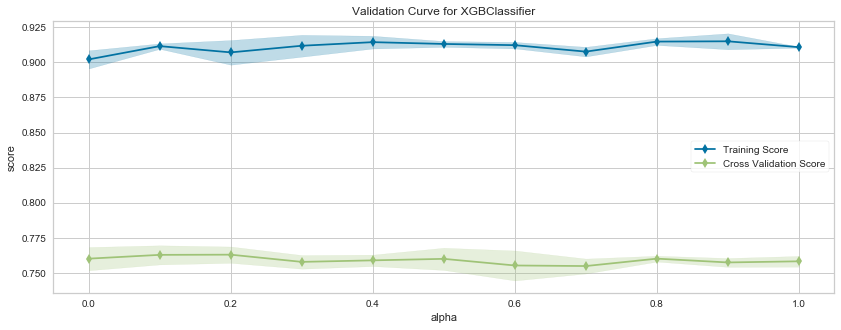

In [ ]:
plot_param_effect(XGBClassifier, "alpha", np.arange(0,1.1,.1), scoring="recall")

C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


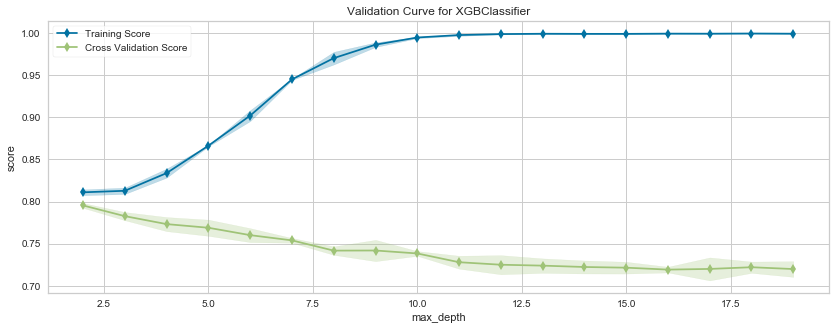

In [ ]:
plot_param_effect(XGBClassifier, "max_depth", np.arange(2,20,1), scoring="recall")

C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


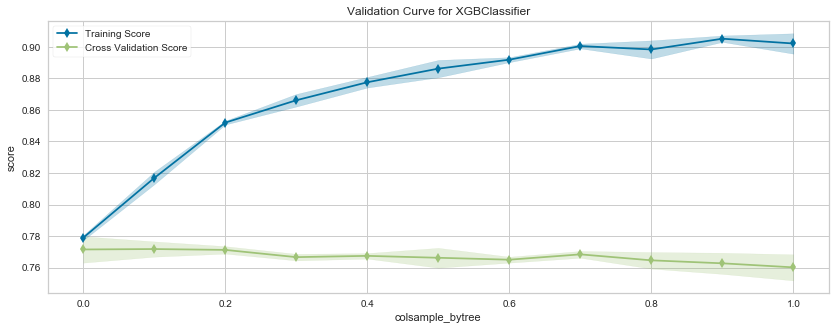

In [ ]:
plot_param_effect(XGBClassifier, "colsample_bytree", np.arange(0,1.1,.1), scoring="recall")

C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


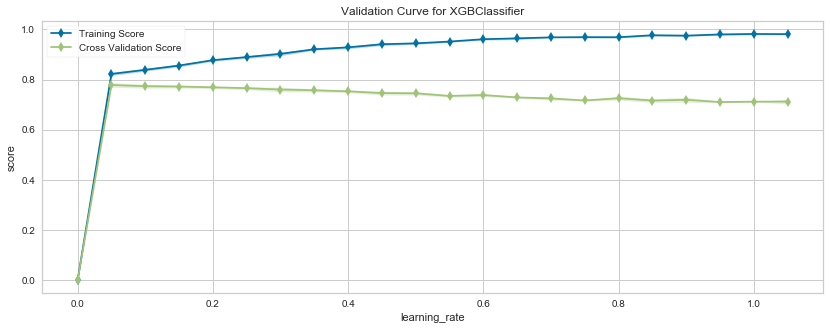

In [ ]:
plot_param_effect(XGBClassifier, "learning_rate", np.arange(0,1.1,.05), scoring="recall")

C:\Users\jonas.j.torres\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


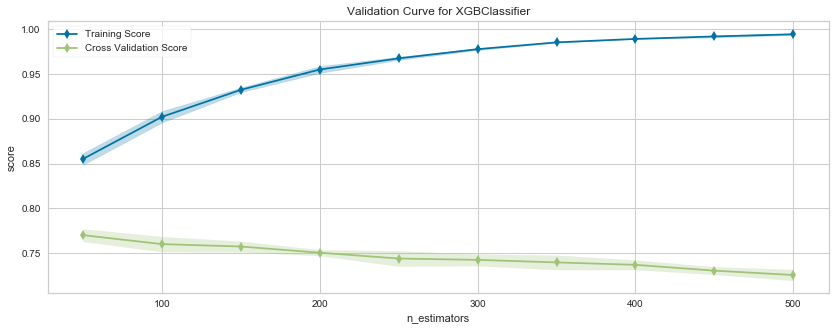

In [ ]:
plot_param_effect(XGBClassifier, "n_estimators", np.arange(50,550,50), scoring="recall")

#### Configuración de parametros en XGboost

In [ ]:
grid_xgb  ={
    'alpha': [0.2,1],  
    'learning_rate': [.05], # vuelve a cada boosting mas conservador
    'colsample_bytree': [.2,.8], # use 20%de las columnas en cada árbol
    'max_depth': [1,2],
    'early_stopping_rounds':[50],
    'n_estimators': np.arange(50,51,500),
    'random_state':[seed]
}

In [ ]:
xgb_cv = GridSearchCV(XGBClassifier(random_state=seed),
      grid_xgb, n_jobs=-1, cv=5, scoring = "recall").fit(X_train, y_train, eval_set=[(X_test, y_test)] ) 

[0]	validation_0-error:0.31964
[1]	validation_0-error:0.30828
[2]	validation_0-error:0.32080
[3]	validation_0-error:0.32226
[4]	validation_0-error:0.31585
[5]	validation_0-error:0.31614
[6]	validation_0-error:0.31410
[7]	validation_0-error:0.31235
[8]	validation_0-error:0.31148
[9]	validation_0-error:0.30973
[10]	validation_0-error:0.30973
[11]	validation_0-error:0.30915
[12]	validation_0-error:0.30099
[13]	validation_0-error:0.29779
[14]	validation_0-error:0.29749
[15]	validation_0-error:0.30099
[16]	validation_0-error:0.29953
[17]	validation_0-error:0.29720
[18]	validation_0-error:0.29691
[19]	validation_0-error:0.29604
[20]	validation_0-error:0.29749
[21]	validation_0-error:0.29779
[22]	validation_0-error:0.29779
[23]	validation_0-error:0.29633
[24]	validation_0-error:0.29429
[25]	validation_0-error:0.29429
[26]	validation_0-error:0.29458
[27]	validation_0-error:0.29371
[28]	validation_0-error:0.29371
[29]	validation_0-error:0.29312
[30]	validation_0-error:0.29312
[31]	validation_0-

In [ ]:
xgb_cv.best_params_

{'alpha': 1,
 'colsample_bytree': 0.8,
 'early_stopping_rounds': 50,
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 50,
 'random_state': 1501}

In [ ]:
xgb_best = XGBClassifier(**xgb_cv.best_params_)
xgb_best.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, early_stopping_rounds=50,
       gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints=None, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=nan,
       monotone_constraints=None, n_estimators=50, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic', random_state=1501,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
y_train_pred_xgb_best = xgb_best.predict(X_train)
y_test_pred_xgb_best = xgb_best.predict(X_test)

In [ ]:
y_hold_pred_xgb_grid = xgb_best.predict(X_holdout)

In [ ]:
# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred_xgb_best,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred_xgb_best,y_test))

Accuracy sobre conjunto de Train: 0.7140463354218272
Accuracy sobre conjunto de Test: 0.7092074592074592


In [ ]:
best_model_dict["xgb_best_eng_df"] = {"holdout_accuracy": accuracy_score(y_holdout,y_hold_pred_xgb_grid),
                                "holdout_recall": metrics.recall_score(y_holdout,y_hold_pred_xgb_grid),
                                "holdout_precision":metrics.precision_score(y_holdout,y_hold_pred_xgb_grid) }

In [ ]:
pd.DataFrame(best_model_dict).T

,holdout_accuracy,holdout_recall,holdout_precision
dt_base_df,0.691783,0.742167,0.700339
dt_eng_df,0.707918,0.750491,0.716026
rf_eng_df,0.712638,0.755403,0.720037
rf_grid_eng_df,0.683272,0.705305,0.702544
xgb_eng_df,0.723650,0.805501,0.713664
xgb_best_eng_df,0.710540,0.834971,0.688817


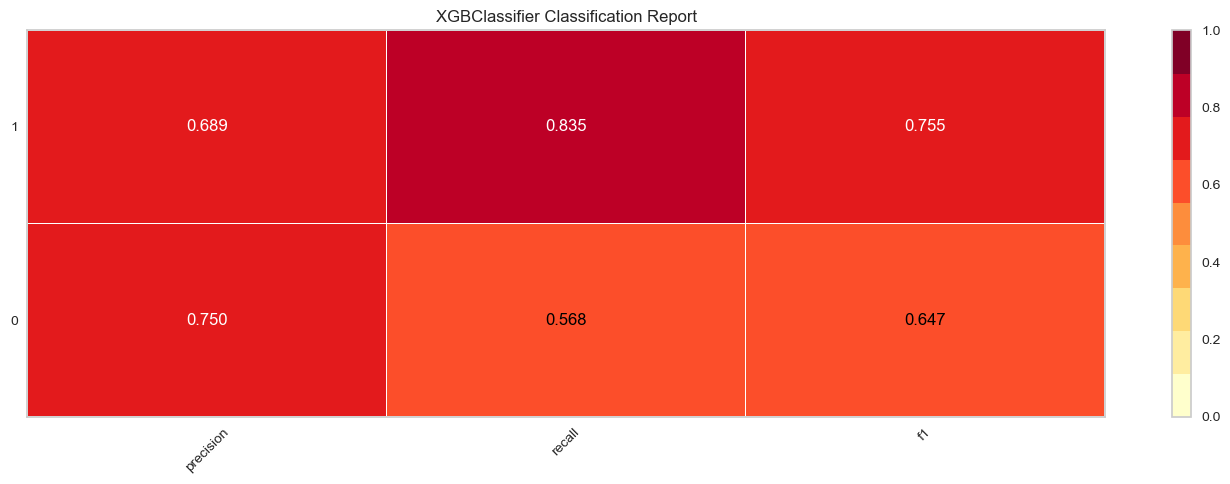

In [ ]:
plot_class_report(xgb_best, X_holdout, y_holdout)

### Predicción sobre todo el dataset

Usaremos el mejor modelo en términos de "recall" para predecir "churn" sobre el dataset entero.

La siguiente tabla nos muestra que el ensemble de XGBoost con los parámetros elegidos via <code>GridSearchCV</code> resultó ser el mejor modelo en términos de "recall" al ser evaluado contra el "holdout" set.

In [ ]:
pd.DataFrame(best_model_dict).T

,holdout_accuracy,holdout_recall,holdout_precision
dt_base_df,0.691783,0.742167,0.700339
dt_eng_df,0.707918,0.750491,0.716026
rf_eng_df,0.712638,0.755403,0.720037
rf_grid_eng_df,0.683272,0.705305,0.702544
xgb_eng_df,0.723650,0.805501,0.713664
xgb_best_eng_df,0.710540,0.834971,0.688817


In [ ]:
df["predicted_churn"] = xgb_best.predict(predictors)

In [ ]:
df[["user_id","target_churn_indicator","predicted_churn"]].to_csv("data_with_predicted_churn.csv")

In [ ]:
metrics.recall_score(y,df["predicted_churn"], average="binary")

0.830659362160047

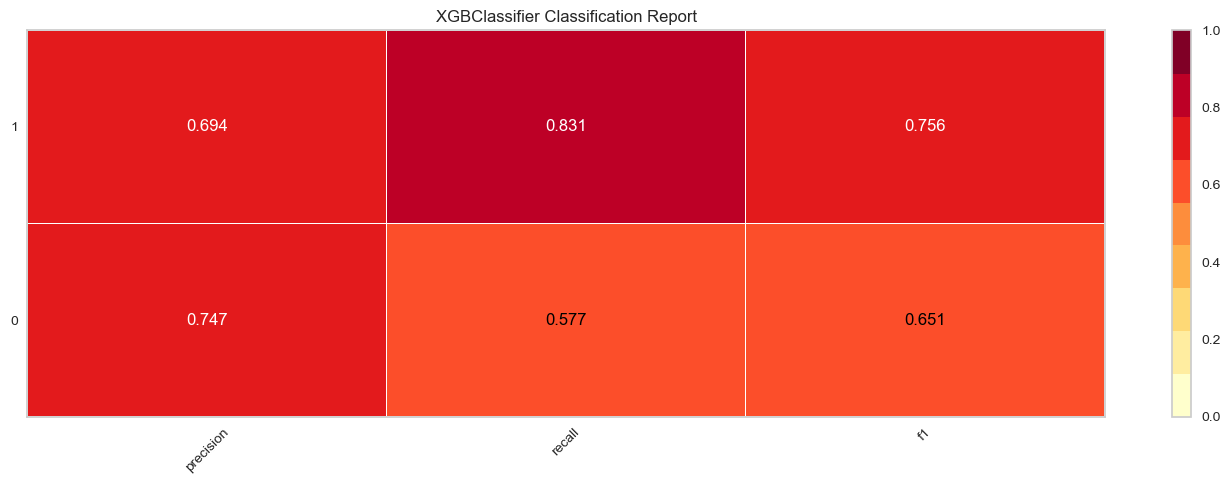

In [ ]:
plot_class_report(xgb_best, predictors, y)

### Variables Importantes

Para interpretar la importancia de las variables, vamos a usar la librería [shap]("https://github.com/slundberg/shap).

**Nota**: La importancia de las variables considerdas por esta librería suelen diferir de las elegidas por <code>plot_importance</code> de xgboost.

In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
shap_ex = shap.TreeExplainer(xgb)
vals = shap_ex.shap_values(predictors)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


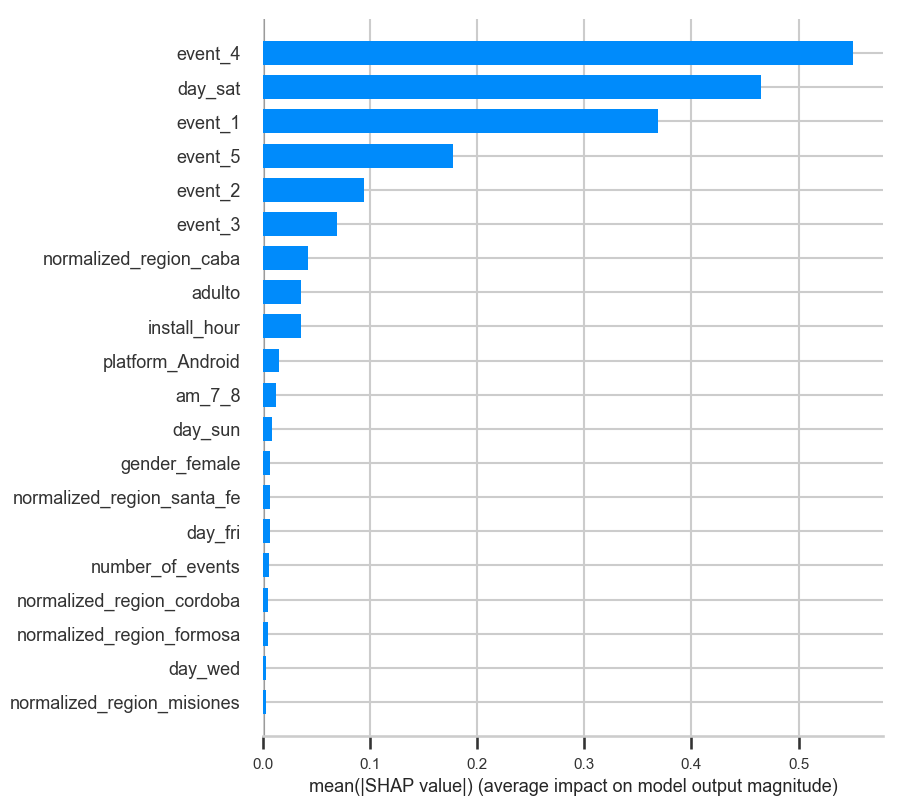

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    shap.summary_plot(vals, predictors, plot_type='bar', show=False)
    plt.savefig('shap_var_imp.png')

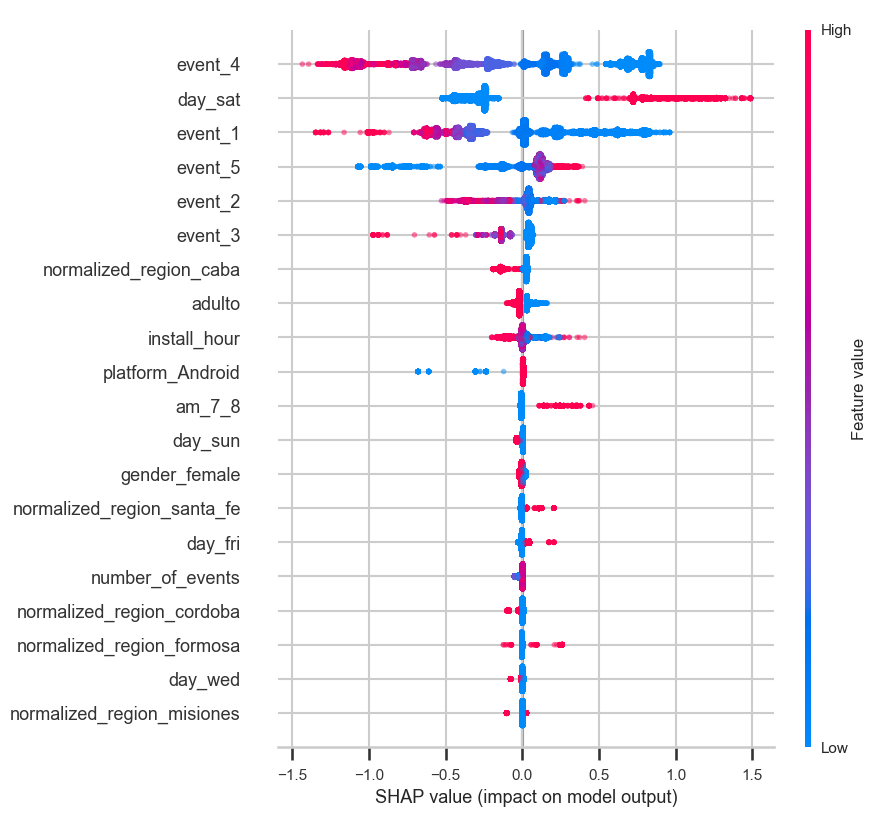

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    shap.summary_plot(vals, predictors, alpha=.5, show=False)
    plt.savefig('shap_summary_plot.png')

### ROC y valor de corte o "cutoff" (No usado en este problema)

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

En este proyecto no voy a alterar el valor de "cutoff" que viene por default en XGBoost.<br>
El código que sigue, es solo para demostrar conocimiento en el uso de la curva ROC para casos en los que un tipo de error, resulte mucho mas "costoso" que otro.

El siguiente gráfico compara las curvas ROC, del modelo XGBoost con parámetros de elegidos con grid serch (arriba a la izquierda), contra la curva del modelo random foresta con valores de default y los árboles de decision por default y contra el dataset, sin las variables creadas.

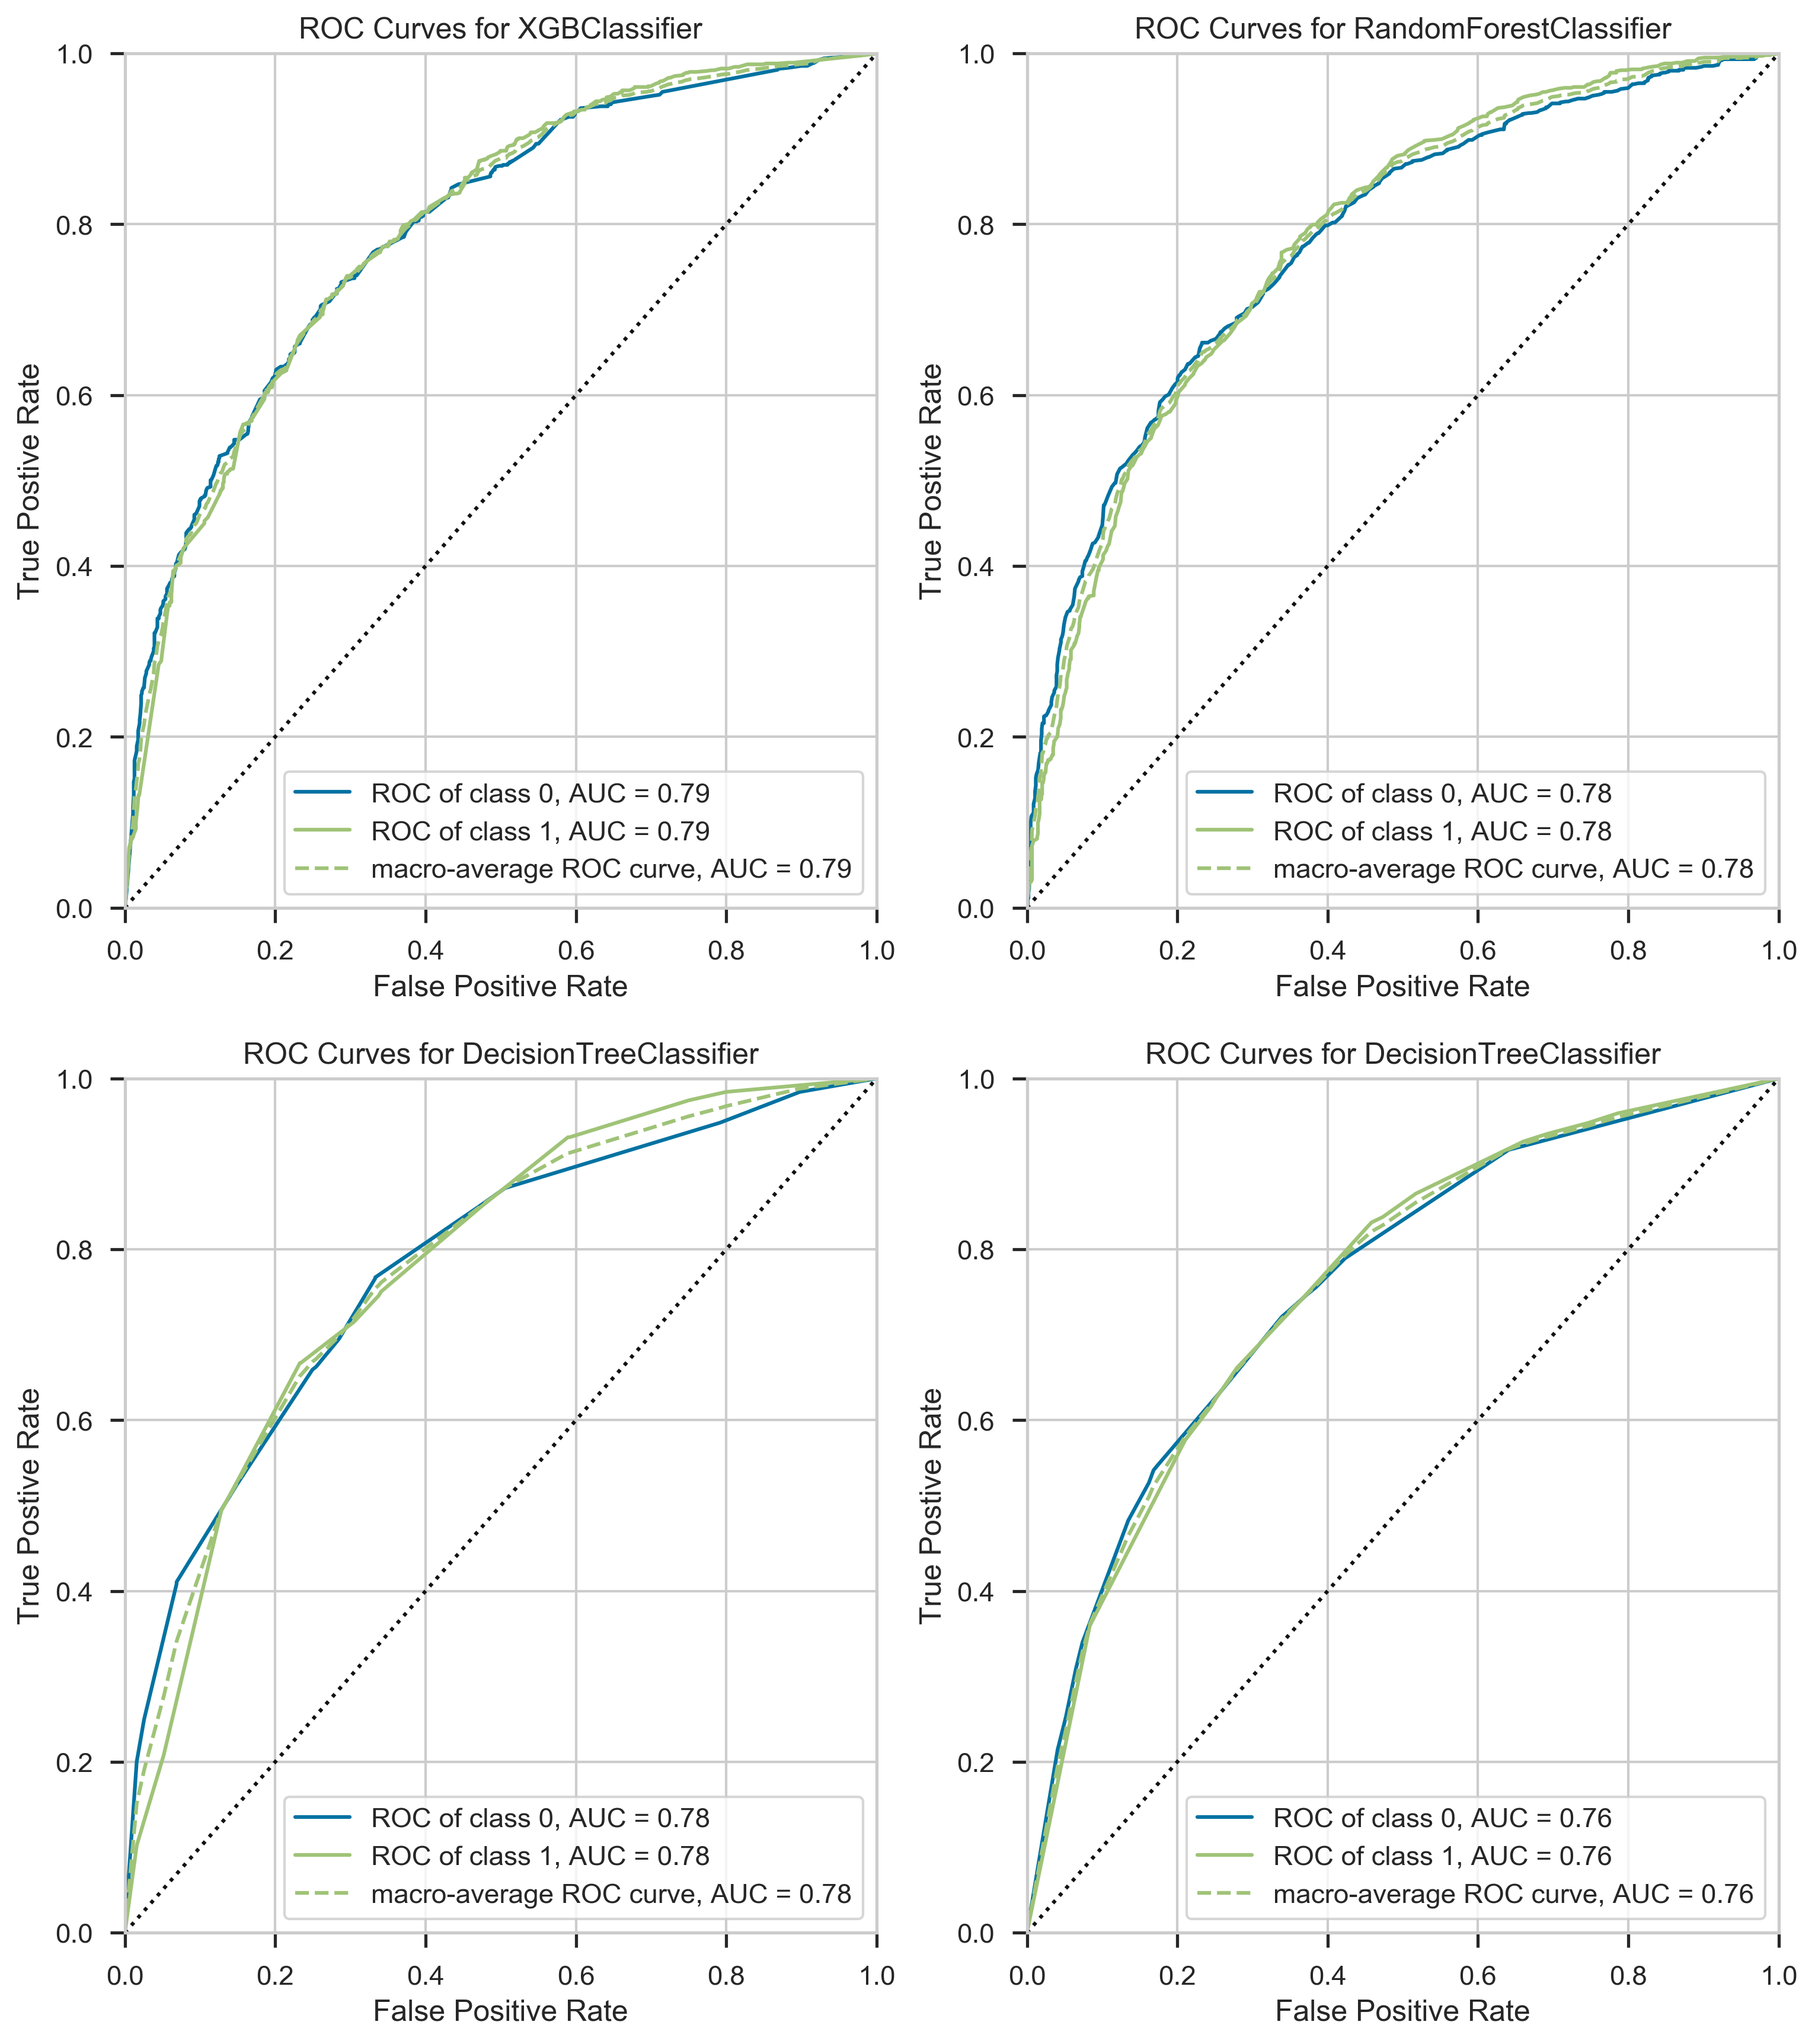

In [ ]:
with sns.plotting_context('notebook'):
    fig, axs = plt.subplots(2,2, figsize=(12,14), dpi=300)
    roc_viz = classifier.ROCAUC(xgb_best, ax=axs[0,0], micro=False)
    roc_viz.score(X_holdout, y_holdout)
    roc_viz.finalize()
    roc_viz2 = classifier.ROCAUC(rf, ax=axs[0,1], micro=False)
    roc_viz2.score(X_holdout, y_holdout)
    roc_viz2.finalize()
    roc_viz3 = classifier.ROCAUC(dt, ax=axs[1,0], micro=False)
    roc_viz3.score(X_holdout, y_holdout)
    roc_viz3.finalize()
    roc_viz4 = classifier.ROCAUC(dt_base_df, ax=axs[1,1], micro=False)
    roc_viz4.score(X_test_base, y_test_base)
    roc_viz4.finalize()

Voy a usar el árbol de clasificación para ilustrar como suelo elegir los "cutoffs" en la práctica, cuando estoy en un escenario de clasificación.

No uso XGBoost ya que el modelo da curvas "suavizadas", y es por eso que a mi criterio, la elección del cutoff con modelos de ensemble, debe hacerse con criterios de negocio y no técnicos.

In [ ]:
probs = dt.predict_proba(X_holdout)
#probs = xgb.predict_proba(X_holdout)

In [ ]:
probs = probs[:,1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_holdout, probs)

In [ ]:
thresholds

array([1.89309366, 0.89309366, 0.77966102, 0.77415307, 0.70756646,
       0.63861386, 0.57142857, 0.56552538, 0.5530303 , 0.50746269,
       0.47096774, 0.41077932, 0.36363636, 0.25037147, 0.20046083,
       0.08606245, 0.        ])

In [ ]:
#simplemente tomo los valores tpr, fpr y threshols y creo un dataframe
frames = [pd.DataFrame(thresholds),pd.DataFrame(fpr),pd.DataFrame(tpr)]

In [ ]:
# Creo la variable "TNR_Speficity" (1-fpr) o "True Negative Rate",
#y "Delta" que representa la diferencia absoluta entre "TPR" y "TNR_Specificity"
cutoffMat = pd.DataFrame({"Thresholds": thresholds,
              "TPR": tpr,
              "FPR":fpr,
              "TNR_Specificity":1-fpr,
              "Delta":abs(tpr -(1-fpr))})


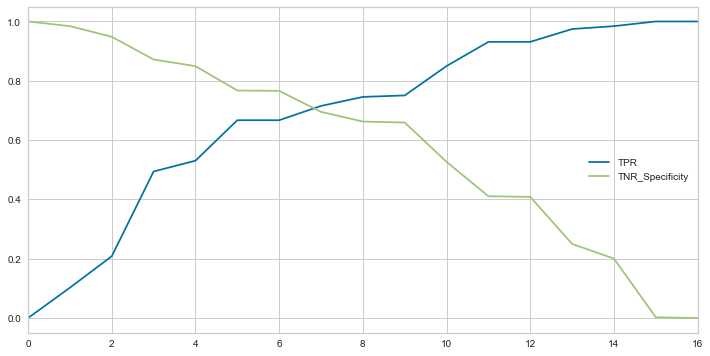

In [ ]:
#grafico la variable "True Positive Rate" contra el "True Negative Rate".
#Donde se cruzan, es donde menor diferencia hay entre ambas.
cutoffMat[["TPR", "TNR_Specificity"]].plot(figsize = (12,6))

En la práctica uso la las curvas para identificar el corte de cutoff "óptimo".

Luego miro la tabla de coeficientes previamente creada para explorar los cutoffs, cercanos a la curva.

In [ ]:
# explor los último 10 valores
cutoffMat

,Thresholds,TPR,FPR,TNR_Specificity,Delta
0,1.893094,0.000000,0.000000,1.000000,1.000000
1,0.893094,0.102161,0.015748,0.984252,0.882091
2,0.779661,0.208251,0.051744,0.948256,0.740005
3,0.774153,0.494106,0.128234,0.871766,0.377660
4,0.707566,0.530452,0.150731,0.849269,0.318817
5,0.638614,0.666994,0.232846,0.767154,0.100160
6,0.571429,0.666994,0.233971,0.766029,0.099035
7,0.565525,0.715128,0.304837,0.695163,0.019965
8,0.553030,0.745580,0.337458,0.662542,0.083037
9,0.507463,0.750491,0.340832,0.659168,0.091324
